## Ensemble BO

https://github.com/zi-w/Ensemble-Bayesian-Optimization/tree/master

### Recap

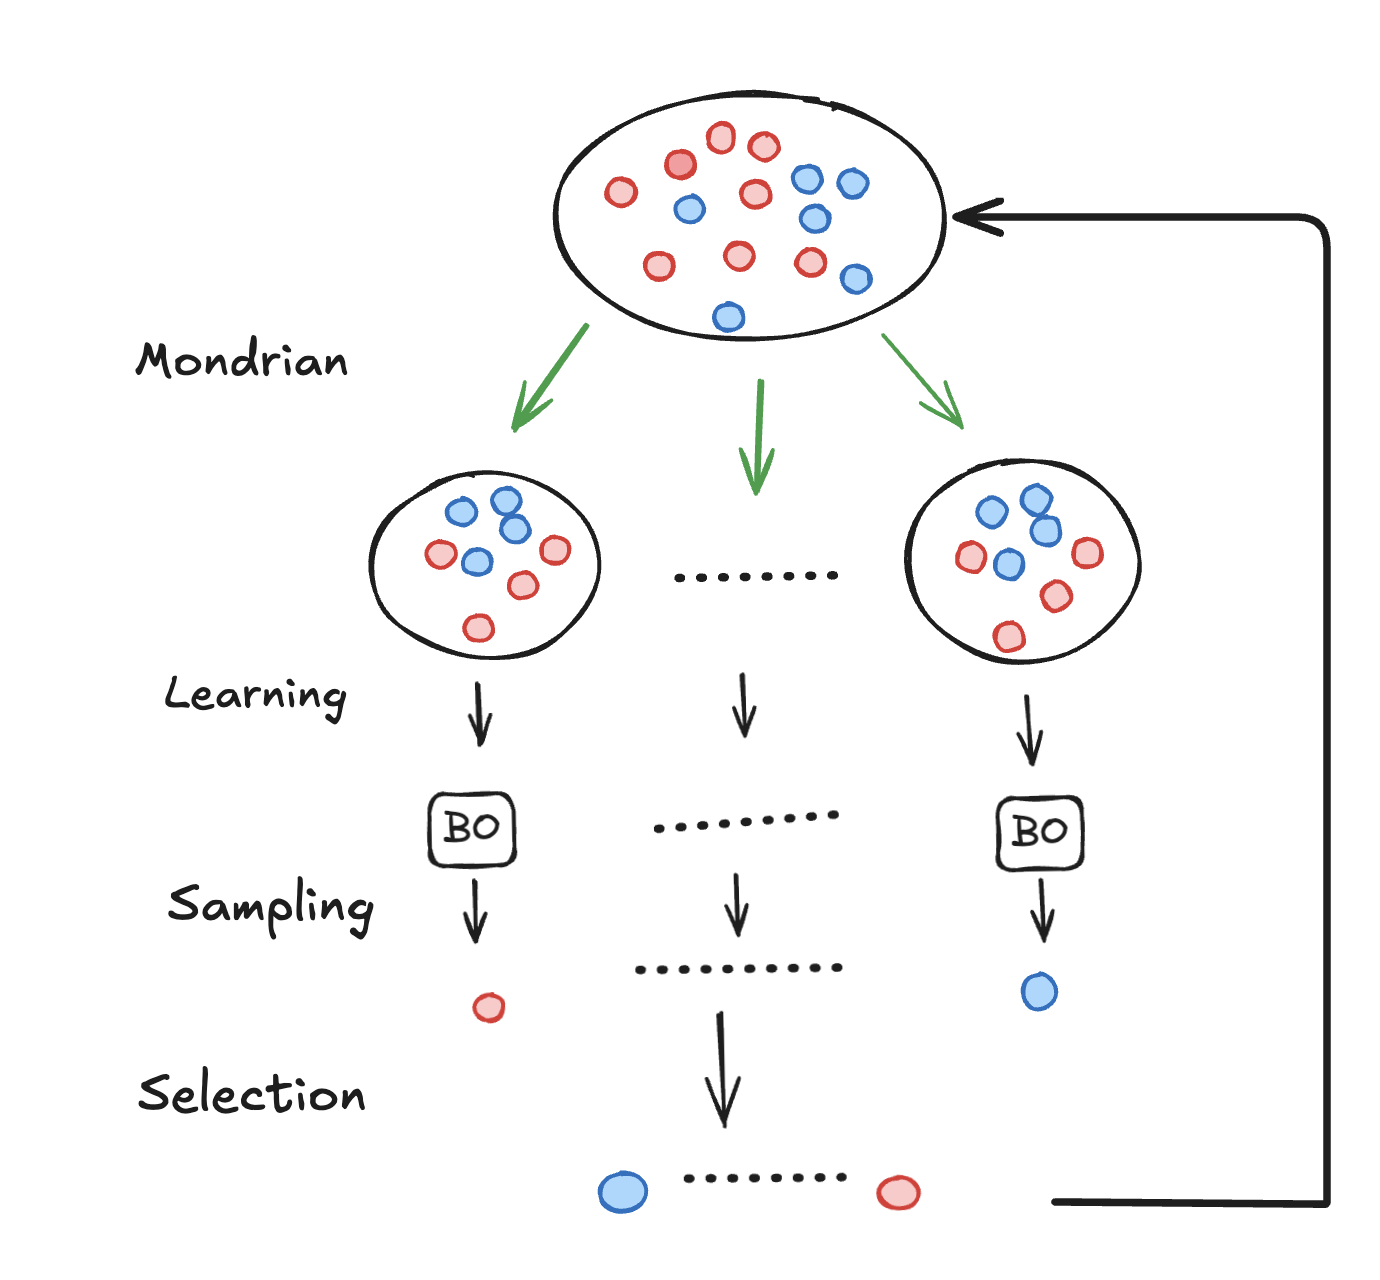

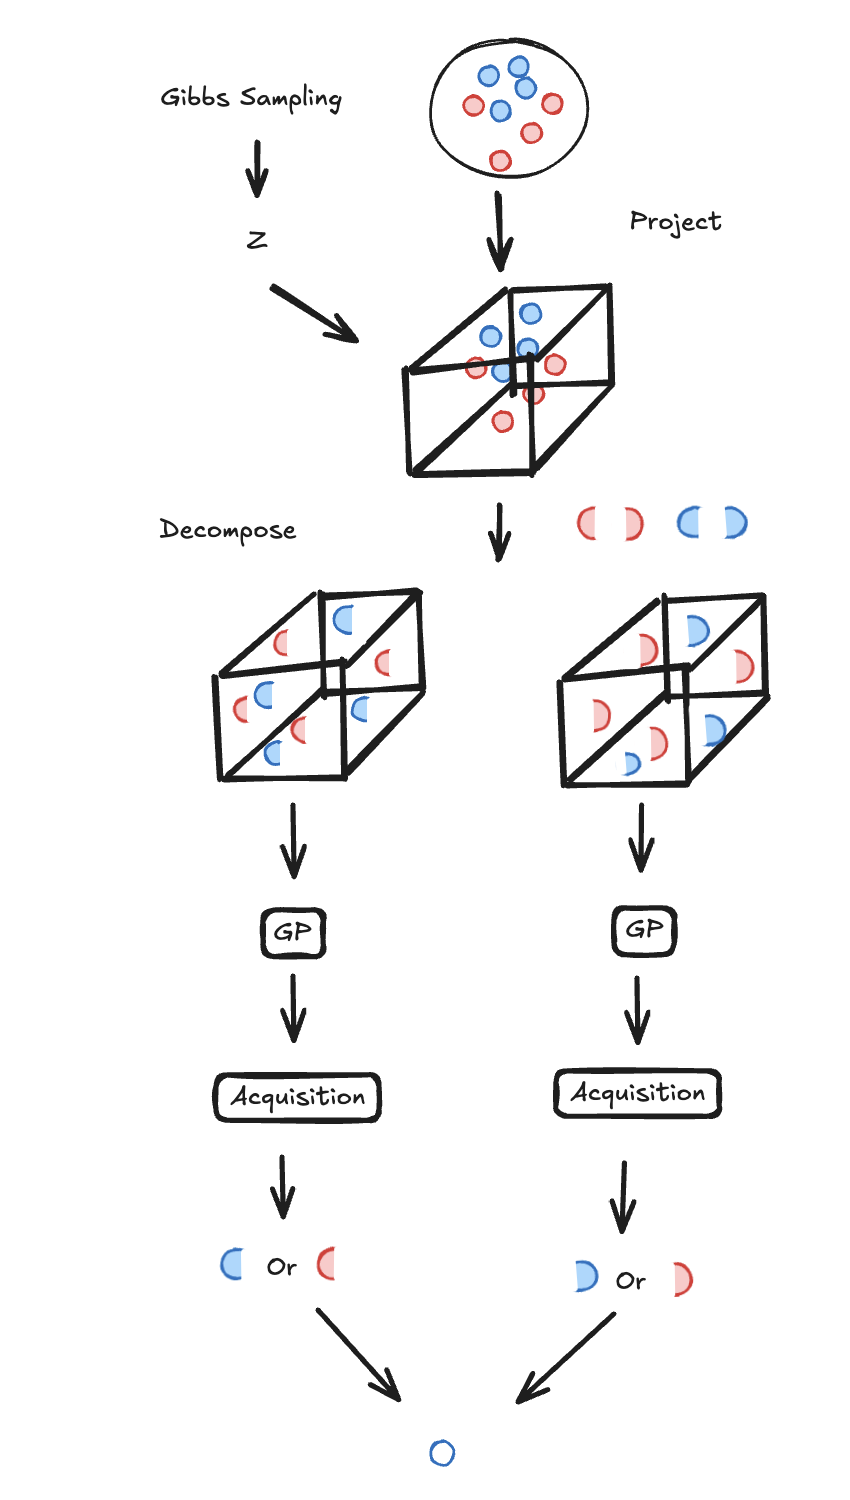

### Set Up

In [ ]:
!apt-get install libsuitesparse-dev && pip install scikit-sparse

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5
0 upgraded, 19 newly installed, 0 to remove and 49 not upgraded.
Need to get 22.4 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.1

In [ ]:
import numpy.matlib

### Helpler

In [ ]:
#!/usr/bin/env python
import numpy as np
import scipy.cluster.hierarchy as hi


def sample_multinomial(prob, shape, dim_limit):
    # assert isinstance(shape, int)
    prob = prob / np.sum(prob)  # normalize the probability distribution
    ret = - np.ones(shape, dtype=np.int64)  # initialize an array with -1 values of the given shape
    for i in range(shape):
        cnt = 0
        while cnt < 100:  # try up to 100 times to sample
            assign = np.random.choice(len(prob), p=prob)  # randomly sample based on probability distribution
            if np.sum(ret == assign) < dim_limit:  # ensure that the same category is not assigned more than the limit
                ret[i] = assign  # assign the sampled value
                break
            cnt += 1
        if cnt >= 100:
            raise ValueError('Not able to sample multinomial with dim limit within 100 rounds.')
    return ret  # return the sampled multinomial array


def sample_categorical(prob):
    prob = prob / np.sum(prob)  # normalize the probability distribution
    return np.random.choice(len(prob), p=prob)  # randomly sample based on the categorical distribution



def find(pred):
    return np.where(pred)[0]  # returns indices where the predicate is True



def gumbel():
    return -np.log(-np.log(np.random.random()))


def mean_z(z_all, dim_limit):
    '''ceate group assignments for the input z_all.
    If any group size exceeds dim_limit, it resamples them using the sample_multinomial function.'''
    # use correlation clustering to average group assignments
    lz = hi.linkage(z_all.T, 'single', 'hamming')  # perform hierarchical clustering with 'single linkage' and 'hamming' distance
    # not sure why cluster id starts from 1
    z = hi.fcluster(lz, 0) - 1  # create flat clusters, subtracting 1 to make the cluster ID start from 0
    all_cat = np.unique(z)  # get unique cluster IDs
    for a in all_cat:
        a_size = np.sum(a == z)  # count the size of each cluster
        if a_size > dim_limit:
            z[a == z] = sample_multinomial([1.] * a_size, a_size, dim_limit)  # resample if the cluster size exceeds the limit
    return z  # return the new cluster assignments


class NormalizedInputFn:
    def __init__(self, fn_instance, x_range):
        self.fn_instance = fn_instance  # function instance to be normalized
        self.x_range = x_range  # input range for normalization

    def __call__(self, x):
        return self.fn_instance(self.project_input(x))  # project input and call the original function

    def project_input(self, x):
        return x * (self.x_range[1] - self.x_range[0]) + self.x_range[0]  # normalize input to the specified range

    def inv_project_input(self, x):
        return (x - self.x_range[0]) / (self.x_range[1] - self.x_range[0])  # inverse the normalization process

    def get_range(self):
        return np.array([np.zeros(self.x_range[0].shape[0]), np.ones(self.x_range[0].shape[0])])  # return a range normalized to [0, 1]


class ConstantOffsetFn:
    #'''is a wrapper class that adds a constant offset to the output of a given function.
    #This is useful when you want to shift the output of a function by a fixed value.'''
    def __init__(self, fn_instance, offset):
        self.fn_instance = fn_instance  # function instance whose output will be offset
        self.offset = offset  # the constant offset to add to the function output

    def __call__(self, x):
        return self.fn_instance(x) + self.offset  # add the constant offset to the function output

    def get_range(self):
        return self.fn_instance.get_range()  # return the range from the original function


### Mondrian

In [ ]:
import numpy as np


class MondrianNode(object):
    def __init__(self, X, y, x_range, reference=None):
        self.X = X  # input data
        self.y = y  # target labels
        self.reference = reference  # reference node
        self.totlen = (x_range[1] - x_range[0]).sum()  # length search space (x_range)
        self.x_range = x_range  # range of input space for this node
        self.get_vol()  # calculate the volume of the node
        assert self.totlen > 0, 'Node is empty. Total length of the search space is 0.'
        self.datasize = y.shape[0]  # number of data points in this node
        self.left = None  # left child node
        self.right = None  # right child node
        self.epsilon = 0.  # overlap of the leaves


        self.maxdata = 1

    def get_vol(self):
      #calculates the volume of the node's region in the search space. If a reference value is provided, it adjusts the volume based on the y values
        if self.reference is not None:
            self.maxy = self.y.max() - self.reference if self.y.shape[0] > 0 else 0  # max value relative to the reference
            self.volumn = np.exp(np.log((self.x_range[1] - self.x_range[0])).sum()) + self.maxy  # the volume, adding maxy
        else:
            self.volumn = np.exp(np.log((self.x_range[1] - self.x_range[0])).sum())  # volume without reference


    def partition(self):
        prob = self.x_range[1] - self.x_range[0]  # ange of each dimension
        assert prob.dtype == float, 'Forgot to set x_range to be float?'
        d = sample_categorical(prob)  # select a dimension for splitting
        cut = np.random.uniform(self.x_range[0, d], self.x_range[1, d])  # a cut point in the selected dimension
        leftinds = np.where(self.X[:, d] <= cut + self.epsilon)  #LEFT child indices cute
        rightinds = np.where(self.X[:, d] >= cut - self.epsilon)  #right child indices
        left_range, right_range = self.x_range.copy(), self.x_range.copy()  # current range for left and right children
        left_range[1, d] = cut  # right boundary for the left child
        right_range[0, d] = cut  # left boundary for the right child
        self.left = MondrianNode(self.X[leftinds], self.y[leftinds], left_range, self.reference)  # leftchild node
        self.right = MondrianNode(self.X[rightinds], self.y[rightinds], right_range, self.reference)  #right child node
        return self.left, self.right  # return the child

    def delete_data(self):
        self.X = None
        self.y = None


class MondrianTree(object):
    def __init__(self, X, y, x_range, poolsize, reference=None):
        self.X = X
        self.y = y
        self.x_range = x_range
        self.root = MondrianNode(X, y, x_range, reference)
        self.poolsize = poolsize
        self.leaves = None

    def grow_tree(self, min_leaf_size):
        leaves = [self.root]
        flag = True
        while flag:
            if len(leaves) >= self.poolsize:  #pool size limit is reached
                break
            prob = np.array([[node.totlen, node.datasize] \
                             for node in leaves])  # probabilities based on total length and size of each node
            mask = np.maximum(prob[:, 1] - min_leaf_size, 0)  # mask for nodes that can still be split
            if mask.sum() == 0:
                print('Mondrian stopped at ', str(len(leaves)), ' number of leaves.' )
                break

            prob = mask * prob[:, 0]  #probabilities for selecting nodes to split
            nodeidx = sample_categorical(prob)  # sample a node index based on the probabilities
            chosen_leaf = leaves[nodeidx]  # select the chosen leaf node for partitioning
            left, right = chosen_leaf.partition()  # partition the selected leaf node
            leaves[nodeidx] = left  # replace the chosen leaf with the left child
            leaves += [right]  # add the right child to the leaves list
            chosen_leaf.delete_data()  # clear data in the chosen leaf node to save memory


        self.leaves = leaves
        return leaves

    def update_leaf_data(self, X, y, ref=None):
        self.X, self.y = X, y
        for n in self.leaves:
            inds = np.where(np.logical_and(X <= n.x_range[1], X >= n.x_range[0]).all(axis=1))  # find the data points within the leaf's range
            n.X = X[inds]
            n.y = y[inds]
            n.reference = ref  # update the reference
            n.get_vol()
        return self.leaves

    def visualize(self):
        if self.leaves is None or self.X.shape[1] != 2:
            print
            'error: x shape is wrong or leaves is none.'

        # visaulize 2d mondrians
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        import matplotlib
        font = {'size': 20}
        matplotlib.rc('font', **font)
        mondrian_colors = np.array([[255, 240, 1], [48, 48, 58],
                                    [255, 1, 1], [1, 1, 253], [249, 249, 249]])
        mondrian_colors = mondrian_colors / 255.0
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        print('number of leaves = {}'.format(len(self.leaves)))
        for node in self.leaves:
            xy = node.x_range[0]
            xylen = node.x_range[1] - node.x_range[0]
            c = mondrian_colors[4]
            p = patches.Rectangle(
                xy, xylen[0], xylen[1],
                facecolor=c,
                linewidth=1,
                edgecolor='k'
            )
            ax.add_patch(p)
        for x in self.X:
            c = '#fdbf6f'
            p = patches.Circle(
                x, 0.01,
                facecolor=c,
                linewidth=0
            )
            ax.add_patch(p)
        return ax, fig


### Gaussian Process

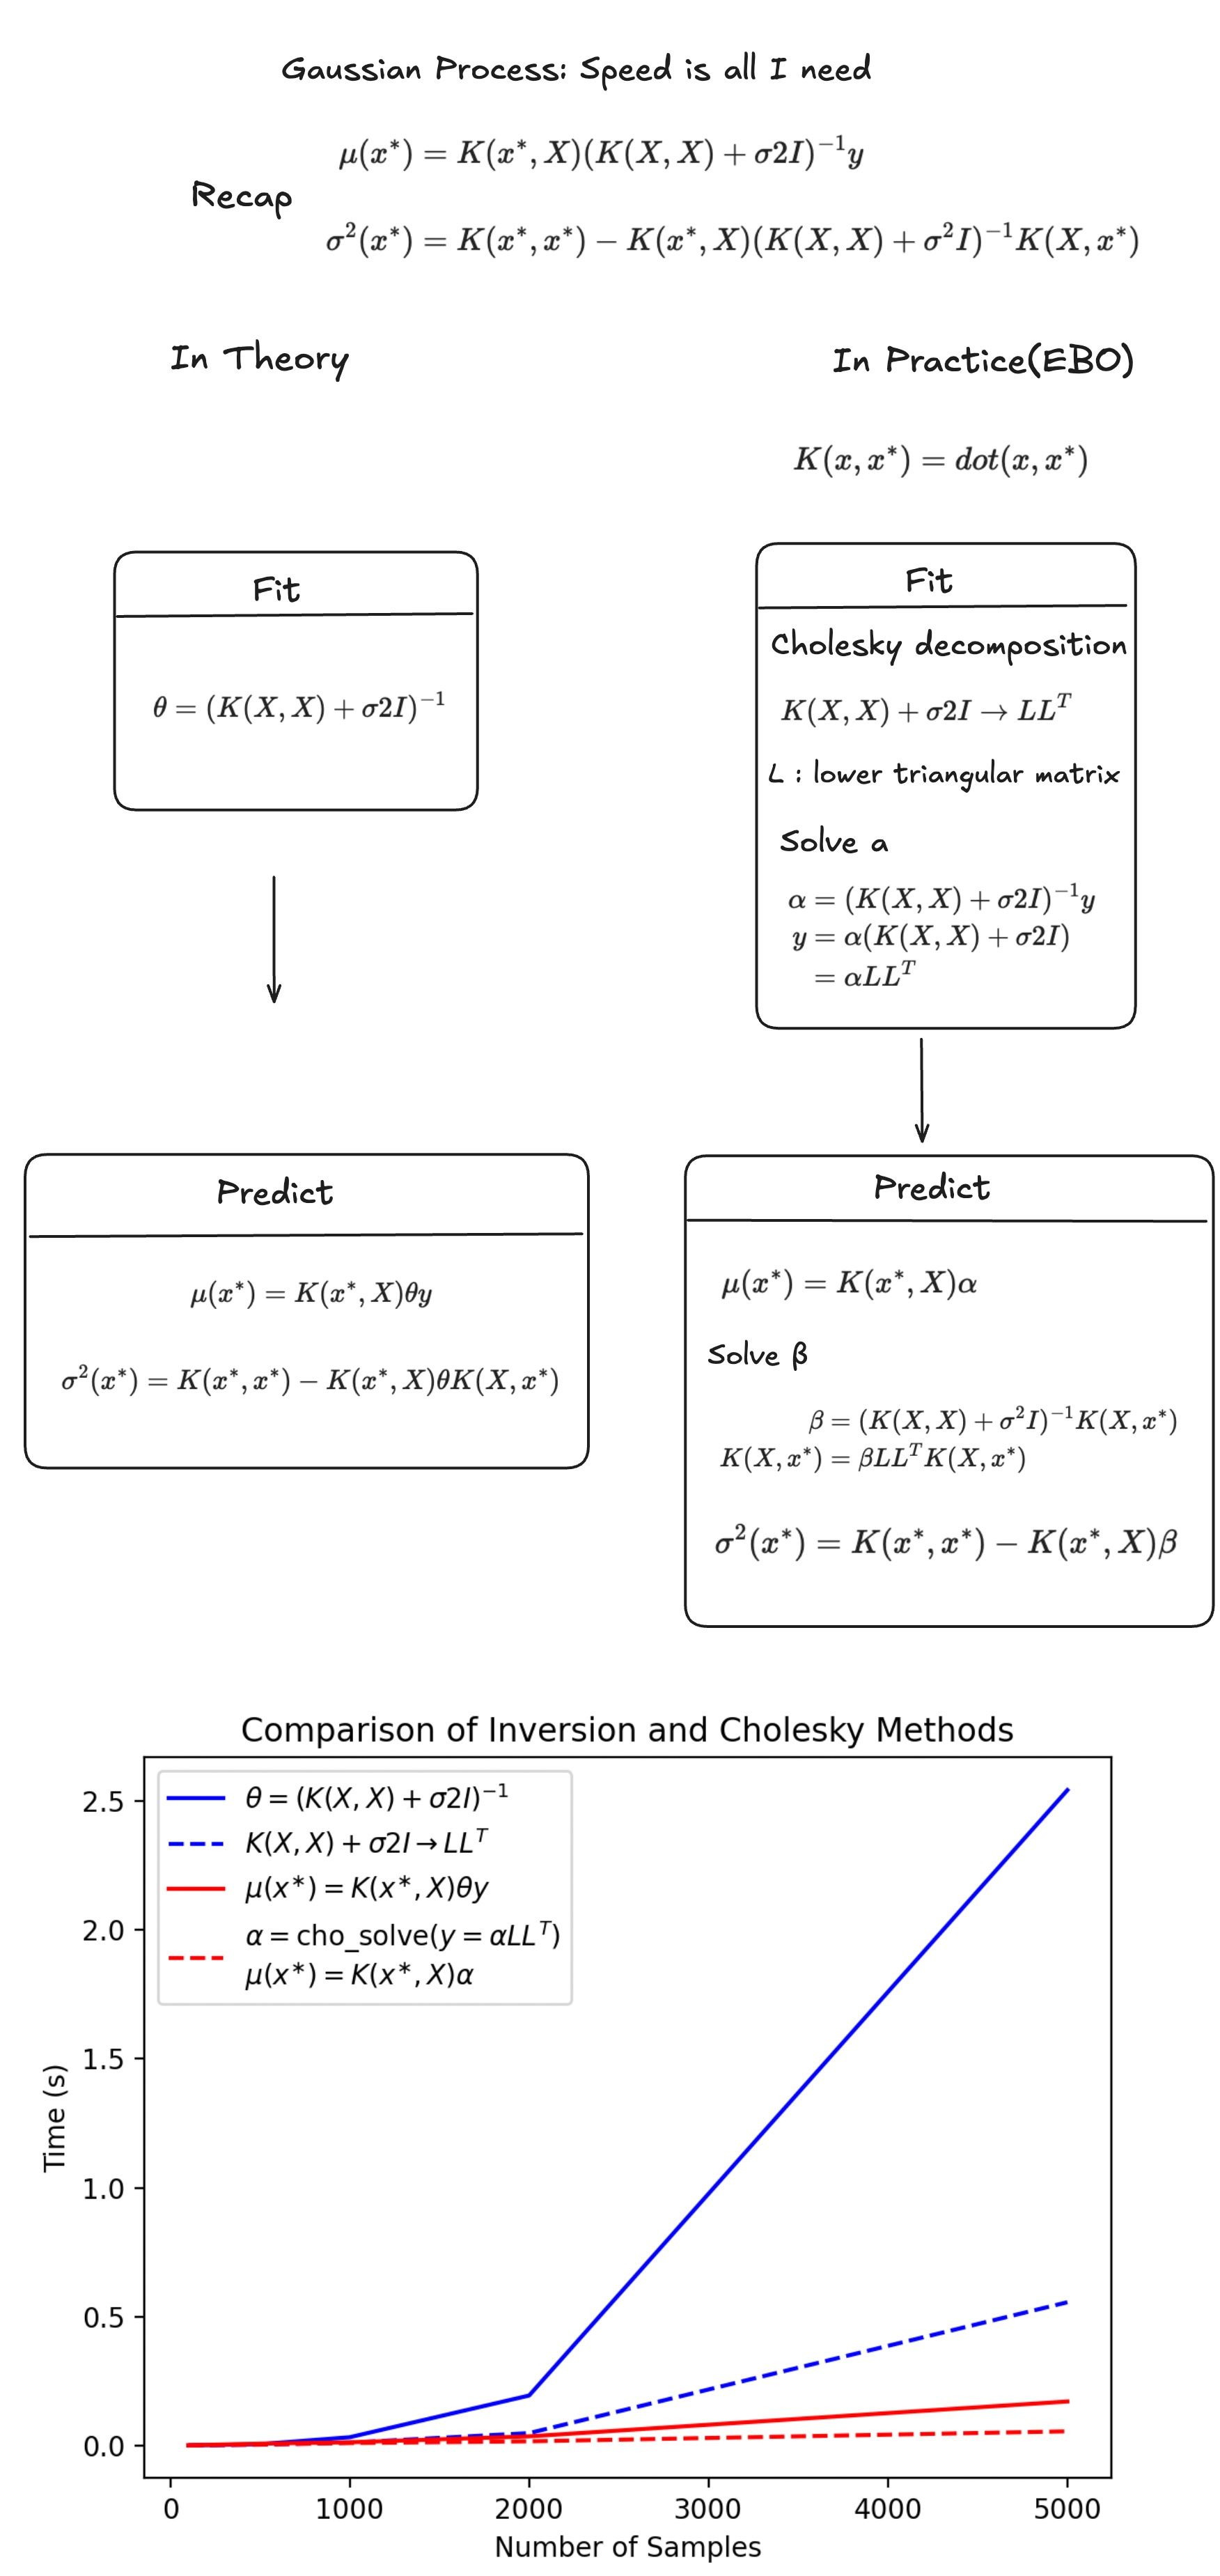

In [ ]:
import numpy as np
import scipy.linalg
import scipy.sparse


import sksparse.cholmod as spch

class SparseFeatureGP:
    def __init__(self, X, y, sigma, phi):
        self.X = X
        self.y = y
        self.sigma = sigma #std fir noise
        self.variance = self.sigma ** 2
        self.phi = phi #feature mapping funcyt
        self.factor = None #Cholesky factorization

    def fit(self):
        n = self.X.shape[0]
        self.mphi = self.phi(self.X)  # feature mapping to the input
        dphi = self.mphi.shape[1]  # dimensionality features
        self.factor = spch.cholesky_AAt(self.mphi.T, beta=self.variance)  # sparse Cholesky decomposition on the feature space

        # precompute some useful quantities
        z = self.mphi.T.dot(self.y)  # compute z, the projection of y into the feature space
        self.theta = self.factor(z)  # solve the system using the Cholesky factor

        # compute the negative log-likelihood (nll)
        ssqr = self.variance  # set var
        ll = 0.5 * (z.T.dot(self.theta) / ssqr - self.factor.logdet()
                    - self.y.T.dot(self.y) / ssqr - np.log(2 * np.pi) * n - np.log(ssqr) * (n - dphi))

        self._nll = -ll[0, 0]  # negative log-likelihood


    def predict(self, X):
        assert self.factor is not None, "The gp must be fit using fit() before predict is called."
        # predict mean
        phiX = self.phi(X)
        mu = phiX.dot(self.theta)

        # predict variance
        var = self.variance * ((phiX.multiply(self.factor(phiX.T).T)).sum(axis=1) + 1.)
        return mu, np.array(var)

    @property
    def nll(self):
        assert self.factor is not None, "The gp must be fit using fit() before querying the neg log likelihood."
        return self._nll


class DenseFeatureGP:
    def __init__(self, X, y, sigma, phi):
        self.X = X
        self.y = y
        self.sigma = sigma
        self.variance = self.sigma ** 2
        self.phi = phi
        self.factor = None

    def fit(self):
        n = self.X.shape[0]
        self.mphi = self.phi(self.X)
        dphi = self.mphi.shape[1] # kernel features martix for dense features

        A = self.mphi.T.dot(self.mphi) + self.variance * np.eye(self.phi.size)
        self.factor = scipy.linalg.cholesky(A)

        # precompute some useful quantities
        z = self.mphi.T.dot(self.y)
        # print self.factor.shape, z.shape
        self.theta = scipy.linalg.cho_solve((self.factor, False), z)

        # compute nll
        logdet = 2 * np.sum(np.log(np.diag(self.factor)))
        ssqr = self.variance
        ll = 0.5 * (z.T.dot(self.theta) / ssqr - logdet - self.y.T.dot(self.y) / ssqr - np.log(2 * np.pi) * n - np.log(
            ssqr) * (n - dphi))

        self._nll = -ll[0, 0]

    def predict(self, X):
        assert self.factor is not None, "The gp must be fit using fit() before predict is called."
        # predict mean
        phiX = np.array(self.phi(X))
        mu = phiX.dot(self.theta)
        # predict variance
        var = self.variance * (1. + np.multiply(phiX,
                                                scipy.linalg.cho_solve((self.factor, False), phiX.T).T).sum(axis=1,
                                                                                                            keepdims=True))
        return mu, var

    @property
    def nll(self):
        assert self.factor is not None, "The gp must be fit using fit() before querying the neg log likelihood."
        return self._nll


class DenseKernelGP(object):
    def __init__(self, X, y, sigma, kern):
        assert X.shape[0] > 0
        self.X = X
        self.y = y
        self.sigma = sigma
        self.variance = sigma ** 2
        self.kern = kern
        self.factor = None
        self.Kinv = None

    def fit(self):
        # gram matrix
        Ky = self.kern(self.X) + self.variance * np.eye(self.X.shape[0])
        # compute K + sigma^2I inverse
        self.factor = scipy.linalg.cholesky(Ky)
        logdet = 2 * np.sum(np.log(np.diag(self.factor)))
        self.alpha = scipy.linalg.cho_solve((self.factor, False), self.y)

        # full nll
        self._nll = 0.5 * (logdet + np.sum(self.alpha * self.y) + self.y.shape[0] * np.log(2 * np.pi))

    def predict(self, X):
        assert self.factor is not None, "The gp must be fit using fit() before predict is called."
        # predict mean
        kXn = np.array(self.kern(X, self.X))
        mu = kXn.dot(self.alpha)
        # predict variance
        var = (self.kern.xTxNorm + self.variance
               - np.multiply(kXn, scipy.linalg.cho_solve((self.factor, False), kXn.T).T).sum(axis=1, keepdims=True))
        return mu, var

    @property
    def nll(self):
        assert self.factor is not None, "The gp must be fit using fit() before querying the neg log likelihood."
        return self._nll


class SparseKernelGP(object):
    def __init__(self, X, y, sigma, kern):
        self.X = X
        self.y = y
        self.sigma = sigma
        self.variance = sigma ** 2
        self.kern = kern
        self.factor = None
        self.Kinv = None

    def fit(self):
        # gram matrix
        Ky = self.kern(self.X)
        if scipy.sparse.isspmatrix_csr(Ky):
            Ky = Ky.T
        self.factor = spch.cholesky(Ky, beta=self.variance)

        # precompute some useful quantities
        self.alpha = self.factor(self.y)

        # partial nnl (ignore what kernel cannot change)
        self._nll = 0.5 * (self.factor.logdet() + np.sum(self.alpha * self.y) + self.y.shape[0] * np.log(2 * np.pi))

    def predict(self, X):
        assert self.factor is not None, "The gp must be fit using fit() before predict is called."
        # predict mean
        kxx = self.kern(X, self.X)
        mu = kxx.dot(self.alpha)

        # predict variance
        var = self.kern.xTxNorm + self.variance - kxx.multiply(self.factor(kxx.T).T).sum(axis=1)

        return mu, np.array(var)

    @property
    def nll(self):
        assert self.factor is not None, "The gp must be fit using fit() before querying the neg log likelihood."
        return self._nll


In [ ]:
from __future__ import print_function
from itertools import chain

try:
    import itertools.zip as zip
except ImportError:
    pass

from builtins import range

import numpy as np
from scipy.sparse import csr_matrix

"""
authors: Clement Gehring
contact: gehring@csail.mit.edu
date: May 2015
"""

################## VARIOUS INTERFACES #######################################
""" Generic map from a state (as an array), to a feature vector (as an array)
"""


class Projector(object):
    def __init__(self):
        pass

    """ Project a vector (or matrix of row vectors) to a corresponding
        feature vector. It should handle 1-D arrays and 2-D arrays.
    """

    def __call__(self, state):
        raise NotImplementedError("Subclasses should implement this!")

    @property
    def size(self):
        raise NotImplementedError("Subclasses should implement this!")


""" Generic map from a state-action pair (as two arrays), to a feature
    vector (as an array)
"""


class StateActionProjector(object):
    def __init__(self):
        pass

    """ Project two vectors (or two matrices of row vectors) to a corresponding
        feature vector. It should handle 1-D arrays and 2-D arrays for both
        arguments and any combination of these cases, i.e., one state but
        several actions and vice-versa.
    """

    def __call__(self, state, action):
        raise NotImplementedError("Subclasses should implement this!")

    @property
    def size(self):
        raise NotImplementedError("Subclasses should implement this!")


""" Hashing an array of indices to a single index.
    Mostly used for tile coding.
"""


class Hashing(object):
    def __init__(self, **kargs):
        pass

    """ Hash several indices (typically, one per dimension) onto
        one index (typically, index of a tile). This could be a simple
        cartesian-product, i.e., unique index for every combination, or
        some sort of randomized hash function, e.g., UNH.

        Must be able to deal with 2D arrays of indices.
    """

    def __call__(self, indices):
        raise NotImplementedError("Subclasses should implement this!")


################## HELPER CLASSES FOR STATE PROJECTOR TO #####################
################## STATE-ACTION PROJECTOR CONVERSION     #####################

""" Simple method that ensures both arrays are 2D and that they share the same
    number of rows (for when only one row was given for one argument but not
    the other).
"""


def tile_and_adjust_state_action(state, action):
    # make everything 2-D
    if state.ndim == 1:
        state = state.reshape((1, -1))
    if action.ndim == 1:
        action = action.reshape((1, -1))

    # if one is 2D and but not the other, tile such that the dimensions
    # match.
    if state.shape[0] == 1 and action.shape[0] > 1:
        state = np.tile(state, (action.shape[0], 1))
    elif action.shape[0] == 1 and state.shape[0] > 1:
        action = np.tile(action, (state.shape[0], 1))

    return state, action


""" Simple state-action projector that simply treats the actions as
    extra dimensions and feeds it to a projector.
"""


class ConcatStateAction(StateActionProjector):
    def __init__(self, projector):
        self.projector = projector

    def __call__(self, state, action):
        state, action = tile_and_adjust_state_action(state, action)

        sa = np.hstack((state, action))
        return self.projector(sa)

    @property
    def size(self):
        return self.projector.size


""" Simple state-action projector that simply ignores the action. Mainly
    to be used when only a value function is needed.
"""


class RemoveAction(StateActionProjector):
    def __init__(self, projector):
        self.projector = projector

    def __call__(self, state, action):
        state, action = tile_and_adjust_state_action(state, action)
        return self.projector(state)

    @property
    def size(self):
        return self.projector.size


""" Create a tabular actions representaton with a state projector. The output
    vectors are padded with zeros such that the total dimension is
    n*num_actions, where n is the output dimension of the projector.

    If action i is given, then the whole vector is zero with the exception
    of columns n*i to n*(i+1), where the projected state will be encoded.

    The resulting output can be either dense or sparse.

"""


class TabularAction(StateActionProjector):
    def __init__(self, projector, num_actions, sparse=True):
        self.phi = projector
        self.__size = self.phi.size * num_actions
        self.num_actions = num_actions
        self.sparse = sparse

    def __call__(self, state, action):
        state, action = tile_and_adjust_state_action(state, action)
        phi_s = self.phi(state)
        phi_s = csr_matrix(phi_s)

        # this step assumes that, if sparse, each row has the same number of
        # non zero elements.
        action = np.tile(action, (1, phi_s.indptr[1] - phi_s.indptr[0])).reshape(-1).astype('int')

        phi_sa = csr_matrix((phi_s.data,
                             phi_s.indices + action * self.phi.size,
                             phi_s.indptr),
                            shape=(phi_s.shape[0], self.size))
        if not self.sparse:
            phi_sa = phi_sa.toarray()
        return phi_sa

    @property
    def size(self):
        return self.__size


################## HELPER CLASS FOR INDEX TO VECTOR CONVERSION ################

""" Projector converting a projector, which generate indices, to a
    projector generating sparse vectors (as a csr matrix)
"""


class IndexToBinarySparse(Projector):
    """ Constructor to go from a projector generating indices to a
        projector generating sparse vectors (as a csr matrix)

        index_projector:    the projector generating indices, it needs to be
                            be able to handle 2-D arrays
    """

    def __init__(self, index_projector, normalize=False):
        super(IndexToBinarySparse, self).__init__()

        self.index_projector = index_projector
        self.normalize = normalize
        if normalize:
            self.entry_value = 1.0 / np.sqrt(self.index_projector.nonzeros)
        else:
            self.entry_value = 1.0

    def __call__(self, state):
        # generate indices for a single (or several) binary sparse vector(s).
        indices = self.index_projector(state)
        if indices.ndim == 1:
            indices = indices.reshape((1, -1))

        # set value of all active features
        vals = np.empty(indices.size)
        vals[:] = self.entry_value

        # create row pointers, this assumes each row has the same number
        # of non-zero entries
        row_ptr = np.arange(0, indices.size + 1, indices.shape[1])

        # flatten the column indices generate ealier
        col_ind = indices.flatten()

        return csr_matrix((vals, col_ind, row_ptr),
                          shape=(indices.shape[0], self.index_projector.size))

    @property
    def size(self):
        return self.index_projector.size

    @property
    def xTxNorm(self):
        return 1.0 if self.normalize else self.index_projector.nonzeros


""" Projector converting a projector, which generate indices, to a
    projector generating dense vectors (as an array)
"""


class IndexToDense(Projector):
    """ Constructor to go from a projector generating indices to a
        projector generating dense vectors (as an array)

        index_projector:    the projector generating indices, it needs to be
                            be able to handle 2-D arrays
    """

    def __init__(self, index_projector, normalize=False):
        super(IndexToDense, self).__init__()

        self.index_projector = index_projector
        self.normalize = normalize
        if normalize:
            self.entry_value = 1.0 / np.sqrt(self.index_projector.nonzeros)
        else:
            self.entry_value = 1.0

    def __call__(self, state):
        # generate indices for a single (or several) binary vectors
        indices = self.index_projector(state)
        if indices.ndim == 1:
            indices = indices.reshape((1, -1))

        # allocate dense array
        output = np.zeros((indices.shape[0], self.size))

        # create row indices
        row_ind = np.tile(np.arange(indices.shape[0]).reshape((-1, 1)),
                          (1, indices.shape[1])).flatten()

        # set values for all active features
        output[row_ind, indices.flatten()] = self.entry_value

        # squeeze out useless dimensions, if any
        return output.squeeze()

    @property
    def size(self):
        return self.index_projector.size

    @property
    def xTxNorm(self):
        return 1.0 if self.normalize else self.index_projector.nonzeros


""" Projector concatenating several projectors into the same representation
    by concatenating their outputs.
"""


class ConcatProjector(Projector):
    def __init__(self, projectors):
        super(ConcatProjector, self).__init__()
        self.phis = projectors

    def __call__(self, state):
        return np.hstack((phi(state) for phi in self.phis))

    @property
    def size(self):
        return sum([phi.size for phi in self.phis])


class SparseRPTilecoding(IndexToBinarySparse):
    def __init__(self, index_projector, random_proj, normalize=False, output_dense=True):
        super(SparseRPTilecoding, self).__init__(index_projector, normalize=normalize)
        self.random_proj = random_proj
        self.output_dense = output_dense

    def __call__(self, X):
        phi = super(self.__class__, self).__call__(X)  #project the input
        pphi = self.random_proj.dot(phi.T).T  # random projection to the sparse features
        if self.output_dense:
            pphi = pphi.todense()
        return pphi


    @property
    def size(self):
        return self.random_proj.shape[0]


################## TILE CODING KERNEL FUNCTION ###############################
class DenseKernel(IndexToBinarySparse):
    def __call__(self, X1, X2=None):
        phi1 = super(self.__class__, self).__call__(X1)
        if X2 is None:
            return phi1.dot(phi1.T).todense()
        else:
            phi2 = super(self.__class__, self).__call__(X2)
            return phi1.dot(phi2.T).todense()


class DenseL1Kernel(object):
    def __init__(self, z, k, scale=1.0):
        self.z = z.copy()
        self.all_cat = np.unique(self.z) #all unique categories in z
        self.n_cat = self.all_cat.shape[0] #of unique categories
        self.k = k * 1.0
        self.scale = scale * 1.0

    def __call__(self, X1, X2=None):
        if X2 is None:
            if X1.ndim == 1:
                return self.scale
            K = 0
            for a in self.all_cat:
                active = self.z == a #active features based on category
                K += computeKmm(X1[:, active], self.k[active], self.scale / self.n_cat)
            return K
        else:
            X1 = X1[None, :] if X1.ndim == 1 else X1
            X2 = X2[None, :] if X2.ndim == 1 else X2
            K = 0
            for a in self.all_cat:
                active = self.z == a
                K += computeKnm(X1[:, active], X2[:, active], self.k[active], self.scale / self.n_cat)
            return K

    @property
    def xTxNorm(self):
        return self.scale


# L1 kernel helpers:
def computeKmm(Xbar, k, scale):
    Xbar = Xbar * k
    Qbar = (Xbar ** 2).sum(axis=1)[:, None]
    l2dist = Qbar + Qbar.T - 2 * (Xbar.dot(Xbar.T))
    l2dist[l2dist < 0] = 0
    ret = scale * np.exp(-np.sqrt(l2dist))
    return ret


def computeKnm(X, Xbar, k, scale):
    X = X * k
    Xbar = Xbar * k
    Q = (X ** 2).sum(axis=1)[:, None]
    Qbar = (Xbar ** 2).sum(axis=1)[:, None]
    l2dist = Q + Qbar.T - 2 * (X.dot(Xbar.T))
    l2dist[l2dist < 0] = 0

    ret = scale * np.exp(-np.sqrt(l2dist))
    return ret


class SparseKernel(IndexToBinarySparse):
    def __call__(self, X1, X2=None):
        phi1 = super(self.__class__, self).__call__(X1)
        if X2 is None:
            return phi1.dot(phi1.T)
        else:
            phi2 = super(self.__class__, self).__call__(X2)
            return phi1.dot(phi2.T)


################## TILE CODING IMPLEMENTATION ################################

""" Represents a series of layer of tile coding. This is equivalent to a single
    discretization of the input space.
"""


class Tiling(object):
    """ Constructor for a set of tilings.

        input_index: array (or list) of the input indices to be considered. This allows
                     to specify on which inputs are the tilings defined.

        ntiles: integer, or array of integers, specifying how many uniform
                divisions for each dimension (or all dimensions if a single
                integer is given). Each layer in this set will have the same
                number of divisions in each dimension.

        ntilings: The number of individual layers in this set of tilings.

        state_range:    range of each dimension

        offset: (optional) the offsets between each layer in this set of
                tilings. By default, each layer is uniformly offset from
                each other. Shape: (#dimensions, ntilings), i.e. for each
                dimension you have to specify the offset of each tiling. For
                dimension d, the offset should be negative and > -1/ntiles[d].
                So if you want random offsets for one dimension, you could use
                something like this:
                -1.0/ntiles[d] * np.random.random_sample(size=ntilings)

        hashing:    (optional) map from the individual bin index for each
                    dimension to a tile index. By default, this is assumed
                    to be a cartesian product, i.e., each combination if
                    mapped to a unique index. This is equivalent to laying a
                    grid over all input dimensions at once. Alternatively,
                    this could map could be defined by a random hash funciton
                    (e.g., UNH).
    """

    def __init__(self,
                 input_index,
                 ntiles,
                 ntilings,
                 state_range,
                 rnd_stream,
                 offset=None,
                 hashing=None):

        self.hashing = hashing

        if isinstance(ntiles, int):
            ntiles = np.array([ntiles] * len(input_index), dtype='int')
        else:
            ntiles = np.array(ntiles)

        self.state_range = [state_range[0][input_index].copy().astype(float)[None, :, None],
                            state_range[1][input_index].copy().astype(float)[None, :, None]]

        if ntiles.ndim > 1:
            ntiles = ntiles[None, :, :]
        else:
            ntiles = ntiles[None, :, None]

        self.state_range[0] = self.state_range[0] - (self.state_range[1] - self.state_range[0]) / (ntiles - 1)

        self.offset = offset
        if offset is None:
            self.offset = np.empty((ntiles.shape[1], ntilings))
            for i in range(ntiles.shape[0]):
                self.offset[i, :] = -rnd_stream.random_sample(ntilings) / ntiles[0, i]

        if self.hashing == None:
            self.hashing = IdentityHash(ntiles)

        self.input_index = np.array(input_index, dtype='int')
        self.size = ntilings * (self.hashing.memory)
        self.index_offset = (self.hashing.memory * np.arange(ntilings)).astype('int')
        self.ntiles = ntiles

    def __call__(self, state):
        return self.getIndices(state)

    def getIndices(self, state):
        if state.ndim == 1:
            state = state.reshape((1, -1))[:, :, None]
        else:
            state = state[:, :, None]

        nstate = (state[:, self.input_index, :] - self.state_range[0]) / (self.state_range[1] - self.state_range[0])
        indicies = ((self.offset[None, :, :] + nstate) * self.ntiles).astype(np.int64)
        return self.hashing(indicies) + self.index_offset[None, :]

    @property
    def ntilings(self):
        return self.offset.shape[1]


""" Full tile coding implementation. This represents a projector, from states
    to features.
"""


class TileCoding(Projector):
    """ Constructor for a tile coding projector. The constructor builds
        several sets of individual tilings based on the input arguments.

        input_indicies: a list of arrays of indices. Each array of indicies
                        specifies which input dimensions are considered by
                        each set of tilings. There will be as many sets of
                        tilings as there are array of indices.

                        e.g., input_indices = [ [0,1], [1,2] ] will generate
                        two sets of tilings, one defined on the first and
                        second dimension, and the other on the second and
                        third dimension.

        ntiles: list of a mix of integers or array of integers. This specifies
                the how fine is the discretization in each set of tilings. There
                should be an element (either integer or array of integers) for
                each set of tilings. If a set of tilings is given an integer,
                each dimensions are discretized in that many bins. If a set of
                tilings is given an array, it should be of the same size as
                the number of input dimensions it uses. In this case, it will
                discretize each dimensions in as many bins as the corresponding
                integer in the given array.

                e.g., ntiles = [ 4, [2,6] ] will generate two sets of tilings
                where the first discretizes all its input dimensions in 4 bins,
                and the second discretizes its first input dimension in 2 bins
                and its second, in 6 bins.

        ntilings:   array (or list) of integers corresponding to how many
                    individual layers are in each set of tilings. In this
                    implementation, individual layers in the same set are
                    uniformly offset from each other.

        hashing:    either None, or list of hashing functions. This specifies
                    the hashing function to be used by each set of tilings. It
                    is assumed that each individual layer part of the same set
                    share the same hash funciton. If None is given, then each
                    set of tilings will use a cartesian product, i.e., each
                    combination of indices is mapped to a unique tile. This is
                    equivalent to laying a n-d grid on the input dimensions.

        state_range:    range of each dimension

        offsets:    (optional) the offsets between the layers for each set of
                    tilings. By default, all layers are uniformly offset from
                    each other. If you provide a list of lists of offsets (which
                    is recommended), this must hold: len(offsets) ==
                    len(input_indices). Each item in offsets is passed to the
                    constructor of Tiling, so see there for further
                    documentation.

        bias_term:  (optional) boolean specifying whether to add an extra bias term which
                    is always on. By default, a bias_term is added.


    """

    def __init__(self,
                 input_indices,
                 ntiles,
                 ntilings,
                 hashing,
                 state_range,
                 rnd_stream=None,
                 offsets=None,
                 bias_term=True):
        super(TileCoding, self).__init__()
        if hashing == None:
            hashing = [None] * len(ntilings)
        if offsets is None:
            offsets = [None] * len(input_indices)

        if offsets is None and rnd_stream is None:
            raise Exception(
                'Either offsets for each tiling or a random stream (numpy) needs to be given in the constructor')

        self.state_range = np.array(state_range)
        self.tilings = [Tiling(in_index, nt, t, self.state_range, rnd_stream, offset=o, hashing=h)
                        for in_index, nt, t, h, o
                        in zip(input_indices, ntiles, ntilings, hashing, offsets)]
        self.__size = sum(map(lambda x: x.size, self.tilings))
        self.bias_term = bias_term
        self.index_offset = np.zeros(len(ntilings), dtype='int')
        self.index_offset[1:] = np.cumsum(map(lambda x: x.size, self.tilings[:-1]))
        self.index_offset = np.hstack([np.array([off] * t, dtype='int')
                                       for off, t in zip(self.index_offset, ntilings)])

        if bias_term:
            self.index_offset = np.hstack((self.index_offset, np.array(self.__size, dtype='int')))
            self.__size += 1

        self.__size = int(self.__size)

    """ Map a state vector, or several state vectors, to its corresponding
        tile indices.
    """

    def __call__(self, state):
        if state.ndim == 1:
            state = state.reshape((1, -1))

        # add bias term if needed, concatenate set of indices of all
        # the sets of tilings.
        if self.bias_term:
            indices = np.hstack(chain((t(state) for t in self.tilings),
                                      [np.zeros((state.shape[0], 1), dtype='int')])) \
                      + self.index_offset
        else:
            indices = np.hstack((t(state) for t in self.tilings)) \
                      + self.index_offset

        return indices.squeeze()

    @property
    def size(self):
        return self.__size

    @property
    def nonzeros(self):
        return np.sum([t.ntilings for t in self.tilings]) + (1 if self.bias_term else 0)


class UNH(Hashing):
    # constants were taken from rlpark's implementation.
    increment = 470

    def __init__(self, memory, rnd_stream):
        super(UNH, self).__init__()
        self.rndseq = np.zeros(16384, dtype='int')
        self.memory = int(memory)
        for i in range(4):
            self.rndseq = self.rndseq << 8 | rnd_stream.random_integers(np.iinfo('int16').min,
                                                                        np.iinfo('int16').max,
                                                                        16384) & 0xff

    def __call__(self, indices):
        rnd_seq = self.rndseq
        a = self.increment * np.arange(indices.shape[1])
        index = indices + a[None, :, None]
        index = index - (index.astype(np.int64) / rnd_seq.size) * rnd_seq.size
        hashed_index = (np.sum(rnd_seq[index], axis=1)).astype(np.int64)
        return (hashed_index - (hashed_index / self.memory).astype(np.int64) * self.memory).astype('int')


class IdentityHash(Hashing):
    def __init__(self, dims, wrap=False):
        super(IdentityHash, self).__init__()
        self.memory = np.prod(dims)
        self.dims = dims.astype('int')
        self.wrap = wrap
        self.dim_offset = np.cumprod(np.vstack((np.ones((self.dims.shape[2], 1)), self.dims[0, :0:-1, :])),
                                     axis=0).astype('int')[None, ::-1, :]

    def __call__(self, indices):
        if self.wrap:
            indices = np.remainder(indices, self.dims)
        else:
            indices = np.clip(indices, 0, self.dims - 1)
        return np.sum(indices * self.dim_offset, axis=1)


################## END OF TILE CODING IMPLEMENTATION #########################


################## RBF IMPLEMENTATION ########################################

class RBFCoding(Projector):
    """ Constructor for an RBF encoding.

        stddev: scaling of the dimensions when computing the distance. Each
                dimension needs a scale. If only a 1-D array is given, all
                RBFs are assumed to have the same scaling, otherwise, it is
                assumed that there is a row specifying the scale for each
                RBF.

        c:  centers of the RBFs. The number of rows corresponds to the number
            of RBFs. The number of column should be equal to the input
            dimension. Each row is a center for a RBF.

        normalized: Boolean to decided whether the RBFs should be normalized.

        bias_term:  Boolean to decided whether the output should be augmented
                    with a constant 1.0 bias term.
    """

    def __init__(self,
                 widths,
                 centers,
                 normalized=False,
                 bias_term=True,
                 **params):
        super(RBFCoding, self).__init__()

        # the centers of the rbfs
        self.c = centers.T[None, :, :]

        # the widths of the rbfs, each rbf can have different widths
        if widths.ndim == 1:
            self.w = widths[None, :, None]
        else:
            self.w = widths.T[None, :, :]

        # should the output of the rbfs sum to one
        self.normalized = normalized

        # include a bias term (always equal to one)
        self.bias_term = bias_term

        # size of the encoded vectors
        self.__size = centers.shape[0]

        # if bias term is included, increment the size
        if bias_term:
            self.__size += 1

    def __call__(self, state):
        # if only on 1-D array given, reshape to a compatible shape
        if state.ndim == 1:
            state = state.reshape((1, -1))

        # allocate and set bias term if needed
        last_index = self.size
        output = np.empty((state.shape[0], self.size))
        if self.bias_term:
            last_index -= 1
            output[:, -1] = 1.0

        # compute squared weighted distance distance
        dsqr = -(((state[:, :, None] - self.c) / self.w) ** 2).sum(axis=1)
        if self.normalized:
            # compute the normalized rbfs from the distances
            e_x = np.exp(dsqr - dsqr.min(axis=1)[:, None])
            output[:, :last_index] = e_x / e_x.sum(axis=1)[:, None]
        else:
            # compute the rbfs from the distances
            output[:, :last_index] = np.exp(dsqr)

        # return encoded input, squeeze out extra dimensions (in the case
        # only on input row was given)
        return output.squeeze()

    @property
    def size(self):
        return self.__size


""" Method to generate grids of points (typically for RBF coding).

    state_range: range of each dimension

    num_centers:    An integer or an array (or list) of integers which
                    corresponds the number of points to distribute on each
                    dimensions. If a single integer is given, all dimensions
                    will have the same number of points.
"""


def grid_of_points(state_range, num_centers):
    if isinstance(num_centers, int):
        num_centers = [num_centers] * state_range[0].shape[0]
    points = [np.linspace(start, stop, num, endpoint=True)
              for start, stop, num in zip(state_range[0],
                                           state_range[1],
                                           num_centers)]

    points = np.meshgrid(*points)
    points = np.concatenate([p.reshape((-1, 1)) for p in points], axis=1)
    return points

################## END OF RBF IMPLEMENTATION ##################################


### Gibbs Sampling

In [ ]:
import numpy as np
import sklearn.random_projection as rp
from scipy.special import comb
from builtins import range


# remember to set random seed somewhere
class GibbsSampler(object):
    def __init__(self, X, y, options):
        self.options = options
        x_range, alpha, beta, z, k, dim_limit, n_add, sigma = self.get_params()

        # gp
        self.gp_type = self.options['gp_type']
        self.sigma = sigma
        self.gp_choices = {'l1': self.get_l1gp,
                           'sk': self.get_tilegp,
                           'sf': self.get_tilegp,
                           'dk': self.get_tilegp,
                           'df': self.get_tilegp}
        self.get_gp = self.gp_choices[self.gp_type]

        # data
        self.X = X
        self.y = y
        self.x_range = np.array(x_range)
        self.xdim = x_range.shape[1]

        # gp hyper parameters
        self.beta = beta

        # additive components
        self.n_add = n_add
        self.alpha = alpha
        self.dim_limit = dim_limit

        self.z = z
        if z is None:
            theta = np.random.dirichlet(self.alpha)
            self.z = sample_multinomial(theta, self.xdim, self.dim_limit)

        self.k = k
        if k is None:
            # set the value for lambda
            lmd = np.random.gamma(self.beta[0], self.beta[1], self.xdim)

            self.k = np.maximum(np.random.poisson(lmd), 2)

        # todo:
        self.tilecap = None
        if X.shape[0] != 0:
            self.gp = self.get_gp()

    def get_params(self):
        all_params = ['x_range', 'alpha', 'beta', 'z', 'k', 'dim_limit', 'n_add', 'gp_sigma']
        return [self.options[t] for t in all_params]

    def get_l1gp(self):
        kern = DenseL1Kernel(self.z, self.k)
        gp = DenseKernelGP(self.X, self.y, sigma=self.sigma, kern=kern)
        gp.fit()
        return gp

    def get_tilegp(self):
        nlayers = self.options['nlayers']
        indices = []
        ntiles = []
        hashing = None
        all_cat = np.unique(self.z)
        if self.tilecap:
            hashing_mem = self.tilecap / len(all_cat) / nlayers
            hashing = [rp.UNH(hashing_mem) for _ in range(len(all_cat))]
        for a in all_cat:
            inds = find(self.z == a)
            indices.append(inds)
            ntiles.append(self.k[inds])

        phi = TileCoding(input_indices=indices,
                         # ntiles = input dim x number of layers x tilings
                         ntiles=ntiles,
                         ntilings=[nlayers] * len(indices),
                         hashing=hashing,
                         state_range=self.x_range,
                         rnd_stream=np.random,
                         bias_term=False
                         )

        if self.gp_type == 'sk':
            # densekern > sparsekern \approx sparserp
            sparsekern = SparseKernel(phi, normalize=True)
            gp = SparseKernelGP(self.X, self.y, sigma=0.1, kern=sparsekern)
        elif self.gp_type == 'sf':
            # slow af
            sparsephi = IndexToBinarySparse(phi, normalize=True)
            gp = SparseFeatureGP(self.X, self.y, sigma=0.1, phi=sparsephi)

        elif self.gp_type == 'dk':
            densekern = DenseKernel(phi, normalize=True)
            gp = DenseKernelGP(self.X, self.y, sigma=self.sigma, kern=densekern)
        else:
            random_proj = rp.sparse_random_matrix(300, phi.size, random_state=np.random)
            densephi = SparseRPTilecoding(phi, random_proj=random_proj, normalize=True, output_dense=True)
            gp = DenseFeatureGP(self.X, self.y, sigma=self.sigma, phi=densephi)

        gp.fit()
        return gp

    # idea: can instead get log likelihood on different subset of data for gibbs
    def run(self, niter):
        for i in range(niter):
            # sample z w/ limit on size
            # random permute dimensions
            for d in np.random.permutation(range(self.xdim)):
                # sample z_d
                # initialize
                final_z = self.z.copy()
                zd_old = self.z[d]
                self.z[d] = -1;
                a_size = np.sum(self.z == zd_old)

                max_log_prob_perturbed = np.log(a_size + self.alpha[zd_old]) \
                                         - self.gp.nll + gumbel()

                # find all possible category assignments

                # if z[d] is alone, the possible other category assignment is
                other_cat = np.unique(self.z)
                other_cat = other_cat[np.logical_and(other_cat != zd_old, other_cat != -1)]
                # otherwise, need to remove z[d] and add one additional category
                if a_size > 0 and other_cat.size + 1 < self.n_add:
                    for a in range(self.n_add):
                        if (a not in other_cat) and (a != zd_old):
                            other_cat = np.append(other_cat, [a])
                            break

                # start sampling
                for a in np.random.permutation(other_cat):
                    a_size = np.sum(self.z == a)
                    if a_size < self.dim_limit:
                        self.z[d] = a
                        gp = self.get_gp()
                        log_prob = np.log(a_size + self.alpha[a]) - gp.nll + gumbel()
                        if log_prob > max_log_prob_perturbed:
                            max_log_prob_perturbed = log_prob
                            self.gp = gp
                            final_z = self.z.copy()
                self.z = final_z
                # end of sample z_d

                # sample k_d
                # initialize
                final_k = self.k.copy()
                kd_old = self.k[d]
                beta_post = lambda x: comb(self.beta[0] + x - 1., x) / ((1. / self.beta[1] + 1.) ** x)
                max_log_prob_perturbed = beta_post(kd_old) - self.gp.nll + gumbel()

                # range of k_d is kd_old \pm 5
                other_k = np.arange(-5, 5) + kd_old
                other_k = other_k[np.logical_and(other_k >= 2, other_k != kd_old)]

                # start sampling
                for b in np.random.permutation(other_k):
                    self.k[d] = b
                    gp = self.get_gp()
                    log_prob = beta_post(b) - gp.nll + gumbel()
                    if log_prob > max_log_prob_perturbed:
                        max_log_prob_perturbed = log_prob
                        self.gp = gp
                        final_k = self.k.copy()
                self.k = final_k
        return self.gp, self.z, self.k


### BO

In [ ]:
import numpy as np
from scipy.optimize import minimize


class bo(object):
    def __init__(self, f, X, y, x_range, eval_only, extra, options):
        self.f = f
        self.options = options
        self.eval_only = eval_only

        if eval_only:
            self.newX = extra
        else:
            self.x_range = x_range

            self.well_defined = X.shape[0] > 0
            self.solver = GibbsSampler(X, y, options) # init gibbs for GP inference

            self.opt_n = options['opt_n']
            self.dx = options['dx']
            self.n_bo = extra #   number of points
            self.opt_n = np.maximum(self.opt_n, self.n_bo * 2) #is twice the no of points

        self.max_value = self.options['max_value']
        self.n_bo_top_percent = self.options['n_bo_top_percent'] # top performing point to consider

    def learn(self):
        self.gp, self.z, self.k = self.solver.run(self.options['gibbs_iter'])

    def run(self):
        if self.eval_only:
            ynew = [self.f(x) for x in self.newX]
            return ynew

        # return random inputs if X is empty
        if not self.well_defined:
            xnew = np.random.uniform(self.x_range[0], self.x_range[1], (self.n_bo, self.dx))
            acfnew = [self.max_value] * self.n_bo
            return xnew, acfnew, self.solver.z, self.solver.k

        # learn GP and optimize
        self.learn()
        # initialization
        xnew = np.empty((self.n_bo, self.dx))
        xnew[0] = np.random.uniform(self.x_range[0], self.x_range[1])
        # optimize group by group
        all_cat = np.unique(self.z) #unique cat from cluster analysis
        for a in np.random.permutation(all_cat):
            active = self.z == a
            af = lambda x: acfun(x, xnew[0], active, self.max_value, self.gp) # define acq
            xnew[:, active] = global_minimize(af, self.x_range[:, active], \
                                              self.opt_n, self.n_bo, self.n_bo_top_percent) #optimize
        mu, var = self.gp.predict(xnew)
        acfnew = np.squeeze((self.max_value - mu) / np.sqrt(var))
        return xnew, acfnew, self.z, self.k


def global_minimize(f, x_range, n, n_bo=1, n_bo_top_percent=1.0):
  # random points within the input range and evaluates the function at those points; minimize the acquisition function
    dx = x_range.shape[1]
    tx = np.random.uniform(x_range[0], x_range[1], (n, dx))
    ty = f(tx)
    x0 = tx[ty.argmin()]  # x0 is a 2d array of size 1*dx
    res = minimize(f, x0, bounds=x_range.T, method='L-BFGS-B')
    tx = np.vstack((tx, res.x))
    ty = np.hstack((ty, res.fun))
    inds = ty.argsort()
    thres = np.ceil(n_bo * n_bo_top_percent).astype(int)
    inds_of_inds = np.hstack((range(thres), np.random.permutation(range(thres, len(inds)))))
    inds = inds[inds_of_inds[:n_bo]]
    return tx[inds, :]


def acfun(X, fixX, active_dims, maxval, gp):
  #omputes the acquisition function for a set of points. updates the active dimensions with the new points (X), and uses the GP to predict the mean and variance.
    if len(X.shape) > 1:
        nX = np.matlib.repmat(fixX, X.shape[0], 1)
        nX[:, active_dims] = X
    else:
        nX = fixX
        nX[active_dims] = X
    mu, var = gp.predict(nX)
    assert (var > 0).all(), 'error in acfun: variance <= 0??'

    return np.squeeze((maxval - mu) / np.sqrt(var))


In [ ]:
class MyPool(object):
  #manages a pool of workers for distributed optimization
    def __init__(self, a, b, useAzure, thresAzure):
        if useAzure:
            from azure_tools.azurepool import AzurePool
            self.pool = AzurePool(a, b)
        self.useAzure = useAzure
        self.thresAzure = thresAzure

    def map(self, parameters, job_id, really_useAzure=True):
        if really_useAzure and len(parameters) > self.thresAzure and self.useAzure:
            return self.pool.map(parameters, job_id)
        res = []
        for p in parameters:
            b = bo(*p)
            res.append(b.run())
        return res

    def end(self):
        if self.useAzure:
            self.pool.end()

    def delete_containers(self):
        if self.useAzure:
            self.pool.delete_containers()

### EBO

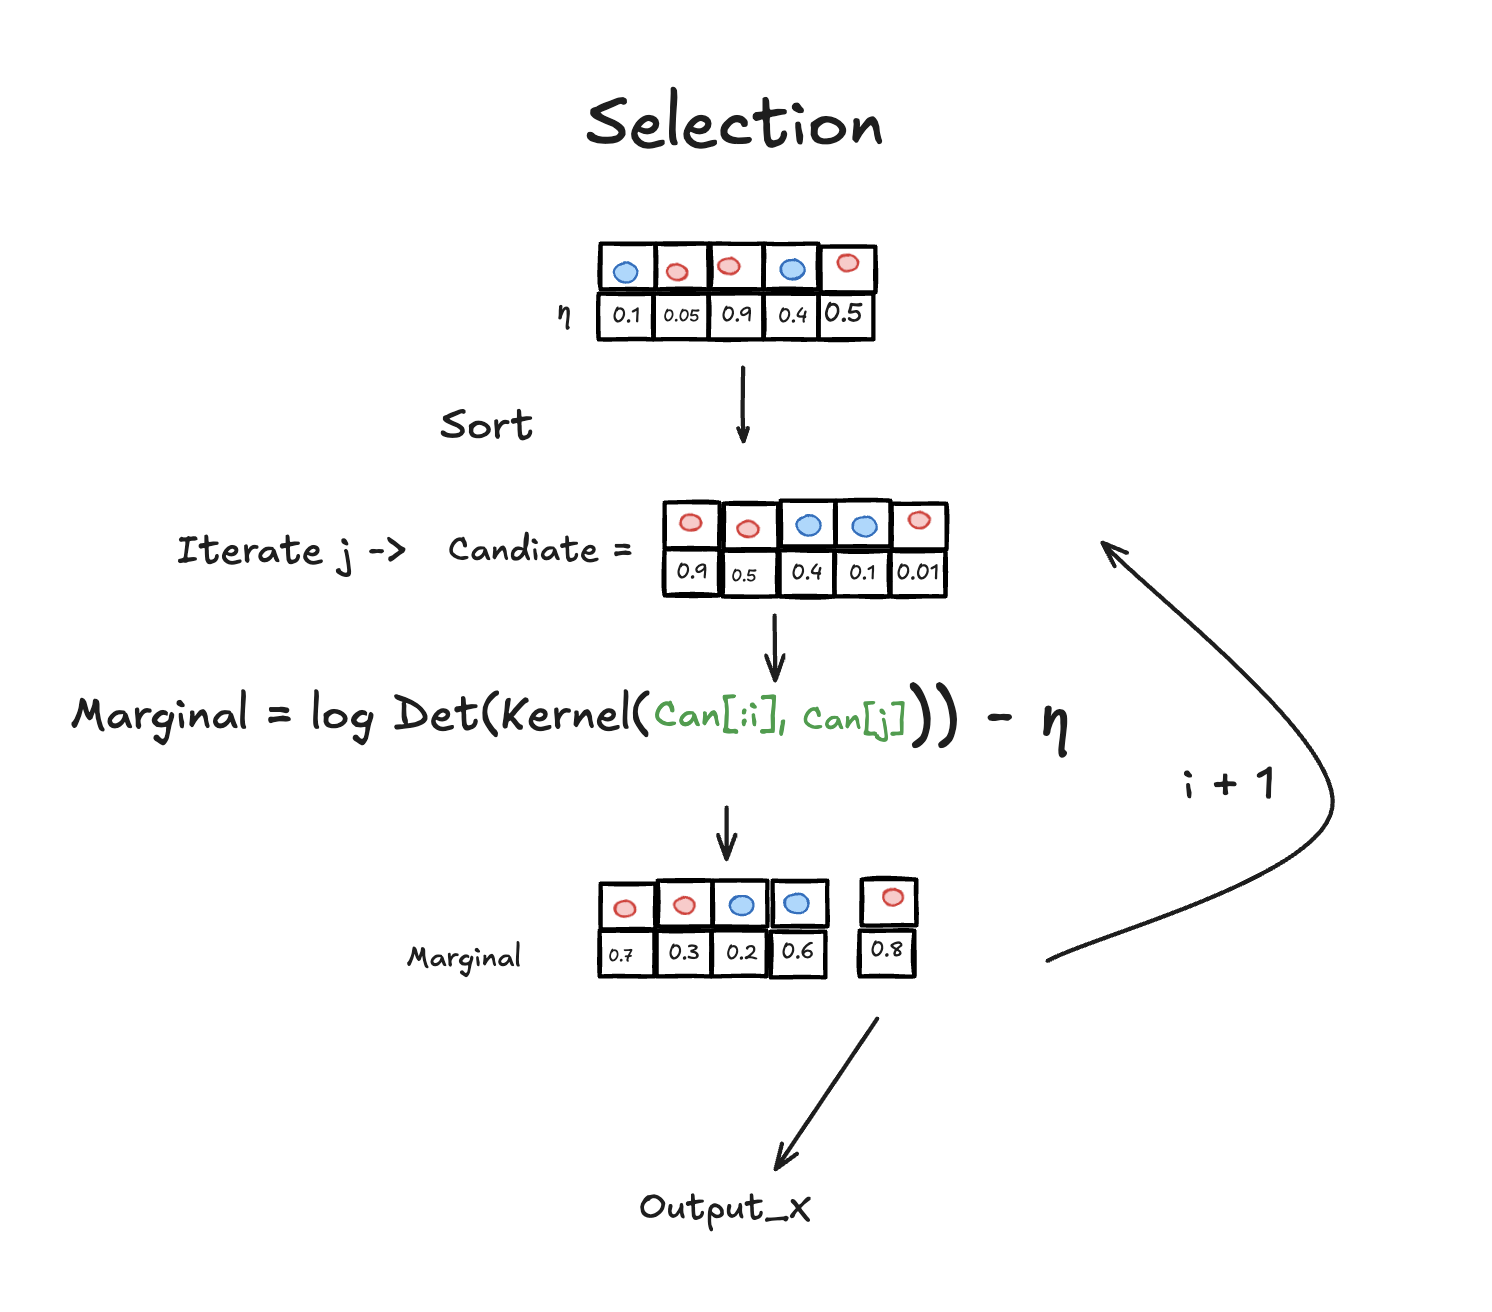

In [ ]:
import os
import time

import numpy as np
from builtins import range

try:
    import cPickle as pickle
except:
    import pickle
import scipy.linalg

'''
Emsemble Bayesian Optimization
'''


class ebo(object):
    def __init__(self, f, options):
        check_valid_options(options)
        self.f = f
        self.options = options
        print(options)
        # initialization
        if 'X' in options and 'y' in options:
            X, y = options['X'], options['y']
        else:
            X, y = np.empty((0, options['dx'])), np.empty((0, 1))

        self.X, self.y = X.copy(), y.copy()
        options['X'], options['y'] = None, None
        # parallel pool
        self.pool = MyPool(options['pid'], options['datadir'], options['useAzure'], options['thresAzure'])
        # hyper parameters
        if 'z' in options and 'k' in options:
            self.z, self.k = options['z'], options['k']
        else:
            self.z, self.k = None

        # for timing
        self.timing = []
        self.variance = options['gp_sigma'] ** 2

    def get_params(self):
        all_params = ['x_range', 'T', 'B', 'dim_limit', 'min_leaf_size', 'max_n_leaves', 'n_bo', 'n_top']
        return [self.options[t] for t in all_params]

    def run(self):
        x_range, T, B, dim_limit, min_leaf_size, max_n_leaves, n_bo, n_top = self.get_params()
        tstart = self.X.shape[0] // B
        for t in range(tstart, T):
            # search space partition
            ref = self.y.min() if self.y.shape[0] > 0 else None
            self.tree = MondrianTree(self.X, self.y, x_range, max_n_leaves, reference=ref)
            leaves = self.tree.grow_tree(min_leaf_size)
            tot_eval = np.ceil(2.0 * B)

            # this might be dangerous if high dimension and R>1
            tot_volumn = np.array([n.volumn for n in leaves]).sum()
            parameters = [[0, n.X, n.y, n.x_range, False,
                           np.maximum(n_bo, np.ceil((tot_eval * n.volumn // tot_volumn)).astype(int)), self.options] for
                          n in leaves]

            # run bo learning in parallel
            start = time.time()
            res = self.pool.map(parameters, 'iter' + str(t))
            elapsed = time.time() - start

            self.timing.append((self.X.shape[0], elapsed))
            # allocate worker budget
            newX, newacf, z_all, k_all = zip(*res)
            # sync hyper parameters

            if self.options['gibbs_iter'] != 0:
                self.z = mean_z(np.array(z_all), dim_limit)
                self.k = np.mean(k_all, axis=0).astype(int)
            # get newX
            newX = np.vstack(newX)
            newacf = np.hstack(newacf)

            newX = self.choose_newX(newX, newacf, n_top, B)

            # map again to evaluate the selected inputs
            parameters = [[self.f, None, None, None, True, [x], self.options] for x in newX]

            newY = self.pool.map(parameters, 'eval' + str(t), not self.options['func_cheap'])
            # update X, y
            self.X = np.vstack((self.X, newX))
            self.y = np.vstack((self.y, newY))

            print(f'budget={B*t}')
            self.print_step(newX, t)

            # save
            # self.save()

        self.pause()


    def choose_newX(self, newX, newacf, n_top, B):
      #chose best input point based on the acq function
        print('start choosing newX')
        start = time.time()
        inds = newacf.argsort()
        if 'heuristic' in self.options and self.options['heuristic']:
            n_top = np.ceil(B / 2.).astype(int)
            inds_of_inds = np.hstack((range(n_top), np.random.permutation(range(n_top, len(inds)))))
            newX = newX[inds[inds_of_inds[:B]]]
            return newX

        good_inds = [inds[0]] * B
        len_inds = len(inds)
        jbest = 0
        maxjbest = 0
        next_ind = 1
        all_candidates = np.arange(1, len_inds)
        #A DenseL1Kernel is used to compute the kernel between points. The loop
        #continues until the required number of points (B) is selected. In each iteration, it selects the best candidate based on the current best points.
        kern = DenseL1Kernel(self.z, self.k)
        rec = []
        while next_ind < B:
            jnext = maxjbest + n_top
            candidates = all_candidates[:jnext]

            #t initializes the variables for tracking the best log-determinant value and the best candidate index.
            #The current best points are extracted for comparison.
            assert len(candidates) > 0, 'B > number of selections?'
            maxlogdet = -np.float64('inf')
            jbest = -1
            curX = newX[good_inds[:next_ind]]

            Ky = kern(curX) + self.variance * np.eye(curX.shape[0])
            # compute K + sigma^2I inverse
            #omputes the kernel matrix (Ky) for the current best points and adds the GP noise (variance).
            #The Cholesky decomposition is used to invert the kernel matrix efficiently.
            factor = scipy.linalg.cholesky(Ky)

            for j in candidates:
                cur_ind = inds[j]
                marginal = self.compute_marginal_det(curX, newX[cur_ind], factor, kern) - newacf[j]

                if maxlogdet < marginal:
                    maxlogdet = marginal
                    jbest = j
            if jbest > maxjbest:
                maxjbest = jbest
            good_inds[next_ind] = inds[jbest]
            all_candidates = all_candidates[all_candidates != jbest]
            next_ind += 1
            rec.append(marginal)
            #After selecting the best points, the method logs the elapsed time and returns the selected points (newX),
            #which are the ones that maximize the acquisition function
        print('finished choosing newX, eplased time = ', time.time() - start)

        return newX[good_inds]

    def compute_marginal_det(self, X, xx, factor, kern):
        kXn = np.array(kern(xx, X))

        det = np.log(kern.xTxNorm - kXn.dot(scipy.linalg.cho_solve((factor, False), kXn.T)).sum())
        return det

    def get_best(self):
      #based on the opserved
        cur = self.y.argmax(axis=0)
        self.bestx, self.besty = self.X[cur], self.y[cur]
        return self.bestx, self.besty, cur

    def print_step(self, newX, t):
        if self.options['isplot']:
            plot_ebo(self.tree, newX, t)
        _, besty, cur = self.get_best()
        print('t=', t, ', bestid=', cur, ', besty=', besty)

        print('final z=', self.z, ' final k=', self.k)


    def reload(self):
        fnm = self.options['save_file_name']
        if not os.path.isfile(fnm):
            return False
        self.X, self.y, self.z, self.k, self.timing = pickle.load(open(fnm))
        print('Successfully reloaded file.')


    # This will save the pool workers
    def pause(self):
        self.pool.delete_containers()

    # end() will release all the workers.
    def end(self):
        self.pool.end()

    def save(self):
        start = time.time()
        fnm = self.options['save_file_name']
        dirnm = os.path.dirname(fnm)
        if not os.path.exists(dirnm):
            os.makedirs(dirnm)
        pickle.dump([self.X, self.y, self.z, self.k, self.timing], open(fnm, 'wb'))
        print('saving file... ', time.time() - start, ' seconds')


def check_valid_options(options):
    all_params = ['x_range', 'dx', 'max_value', \
                  'T', 'B', 'dim_limit', 'isplot', 'z', 'k', 'alpha', 'beta', \
                  'opt_n', 'pid', 'datadir', 'gibbs_iter', 'useAzure', 'n_add', \
                  'gp_type', 'gp_sigma', 'n_bo', 'n_top', 'min_leaf_size', 'func_cheap', 'thresAzure', 'save_file_name']
    #the parameters fare the input range
     #(x_range), dimensionality (dx), GP settings, optimization settings.
    for a in all_params:
        assert a in options, a + ' is not defined in options.'
    assert options['x_range'].shape[1] == options['dx'], 'x_range and dx mismatched.'
    if 'X' in options:
        assert 'y' in options, 'y undefined.'
        assert options['X'].shape[0] == options['y'].shape[0], 'X, y size mismatched.'
        assert options['y'].shape[1] == 1, 'y should be n x 1 matrix.'
        assert options['X'].shape[1] == options['dx'], 'X should be n x dx matrix.'

    # check for gibbs
    beta, alpha, x_range, n_add = options['beta'], options['alpha'], options['x_range'], options['n_add']
    dim_limit = options['dim_limit']
    options['n_add'] = options['dx'] if n_add is None else n_add
    n_add = options['n_add']
    options['dim_limit'] = options['dx'] if dim_limit is None else dim_limit
    assert beta.dtype == float, 'Forgot to set beta to be float?'
    assert isinstance(alpha, float) or alpha.dtype == float, 'Forgot to set alpha to be float?'
    assert x_range.dtype == float, 'Forgot to set x_range to be float?'
    assert len(x_range) == 2 and len(x_range[0]) == len(x_range[1]), 'x_range not well defined'

    if isinstance(alpha, int) or isinstance(alpha, float):
        options['alpha'] = np.array([alpha * 1.0] * n_add)

    assert options['alpha'].shape[0] == n_add, 'alpha must be of size n_add'

    assert options['k'] is None or np.min(options['k']) >= 2, 'number of tiles must be at least 2'


def plot_ebo(tree, newX, t):
    # visualize EBO on 2D function
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    ax, fig = tree.visualize()
    for x in newX:
        c = '#1f78b4'
        p = patches.Circle(
            x, 0.01,
            facecolor=c,
            linewidth=0
        )
        ax.add_patch(p)
    plt.show()
    fig.savefig('ebo_result_iteration_' + str(t) + '.eps', format='eps', dpi=1000)


## Experiments

### Test

In [ ]:
import os

import numpy as np


class SimpleQuadratic(object):
    def __init__(self, dx, z, k):
        self.dx = dx
        self.z = z
        self.k = k

    def __call__(self, x):
        x = np.squeeze(x)
        assert len(x) == self.dx
        f = 0
        for i in range(self.dx):
            f -= ((x[i] - 0.5) ** 2.0) / self.dx
        return f


class SampledGpFunc(object):
    def __init__(self, x_range, dx, z, k, n, sigma):
        self.dx = dx
        self.z = z
        self.k = k
        self.sigma = sigma
        self.x_range = x_range
        kern = DenseL1Kernel(self.z, self.k)

        X = np.random.uniform(x_range[0], x_range[1], (n, dx))
        kxx = kern(X) + sigma ** 2 * np.eye(X.shape[0])
        y = np.random.multivariate_normal(np.zeros(n), kxx).T

        self.gp = DenseKernelGP(X, y, sigma=sigma, kern=kern)
        self.gp.fit()
        self.get_max()

    def get_max(self):
        x = self.x_range[0].copy()
        all_cat = np.unique(self.z)
        for a in all_cat:
            active = self.z == a
            k1 = DenseL1Kernel(self.z[active], self.k[active])
            af = lambda x: np.array(k1(x, self.gp.X[:, active])).dot(self.gp.alpha)
            x[active] = np.squeeze(global_minimize(af, self.x_range[:, active], 10000))

        self.argmax = x
        self.f_max = -np.squeeze(np.array(self.gp.kern(x, self.gp.X)).dot(self.gp.alpha))

    def __call__(self, x):
        if x.ndim == 1:
            n = 1
        else:
            n = x.shape[0]
        kXn = np.array(self.gp.kern(x, self.gp.X))
        mu = kXn.dot(self.gp.alpha)
        f = mu
        f += np.random.normal(size=n) * self.sigma
        return -np.squeeze(f)


def sample_z(dx):
    z = np.zeros(dx, dtype=int)
    cnt = 1
    samecnt = 1
    for i in range(1, dx):
        if (samecnt < 3 and np.random.rand() < 0.5) or (samecnt < 4 and np.random.rand() < 0.1):
            z[i] = z[i - 1]
            samecnt += 1
        else:
            z[i] = cnt
            cnt += 1
            samecnt = 1
    return z


def save_sampled_gp_funcs(dx, n=50, nfunc=1, isplot=1, dirnm='mytests'):
    import cPickle as pic
    for i in range(nfunc):
        sigma = 0.01
        z = sample_z(dx)
        k = np.array([10] * dx)
        x_range = np.matlib.repmat([[0.], [1.]], 1, dx)
        f = SampledGpFunc(x_range, dx, z, k, n, sigma)
        filenm = os.path.join(dirnm, str(i) + '_' + str(dx) + '_f.pk')
        pic.dump(f, open(filenm, 'wb'))

    if isplot:
        plot_f(f)

    return f


def plot_f(f, filenm='test_function.eps'):
    # only for 2D functions
    import matplotlib.pyplot as plt
    import matplotlib
    font = {'size': 20}
    matplotlib.rc('font', **font)

    delta = 0.005
    x = np.arange(0.0, 1.0, delta)
    y = np.arange(0.0, 1.0, delta)
    nx = len(x)
    X, Y = np.meshgrid(x, y)

    xx = np.array((X.ravel(), Y.ravel())).T
    yy = f(xx)

    plt.figure()
    plt.contourf(X, Y, yy.reshape(nx, nx), levels=np.linspace(yy.min(), yy.max(), 40))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.colorbar()
    plt.scatter(f.argmax[0], f.argmax[1], s=180, color='k', marker='+')
    plt.savefig(filenm)


{'x_range': array([[0., 0.],
       [1., 1.]]), 'dx': 2, 'max_value': 2.244609735165762, 'T': 10, 'B': 10, 'dim_limit': 3, 'isplot': 1, 'z': None, 'k': None, 'alpha': array([1., 1.]), 'beta': array([5., 2.]), 'opt_n': 1000, 'pid': 'test3', 'datadir': 'tmp_data/', 'gibbs_iter': 10, 'useAzure': False, 'func_cheap': True, 'n_add': 2, 'nlayers': 100, 'gp_type': 'l1', 'gp_sigma': 0.1, 'n_bo': 10, 'n_bo_top_percent': 0.5, 'n_top': 10, 'min_leaf_size': 10, 'max_n_leaves': 10, 'thresAzure': 1, 'save_file_name': 'tmp/tmp.pk'}
start choosing newX
finished choosing newX, eplased time =  0.013983726501464844
number of leaves = 1


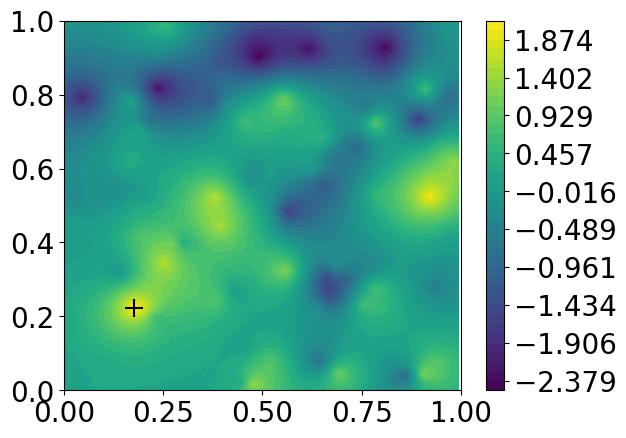

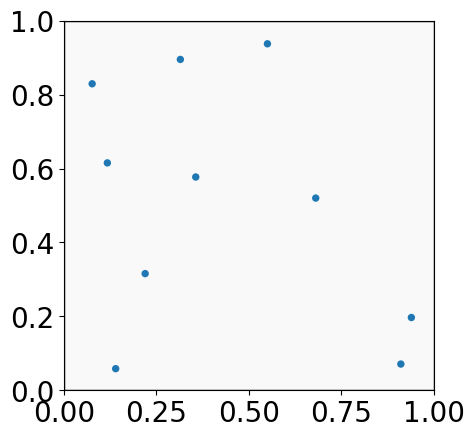

t= 0 , bestid= [5] , besty= [[1.1115825]]
final z= [0 0]  final k= [6 7]
saving file...  0.004563331604003906  seconds
start choosing newX
finished choosing newX, eplased time =  0.027493715286254883
number of leaves = 1


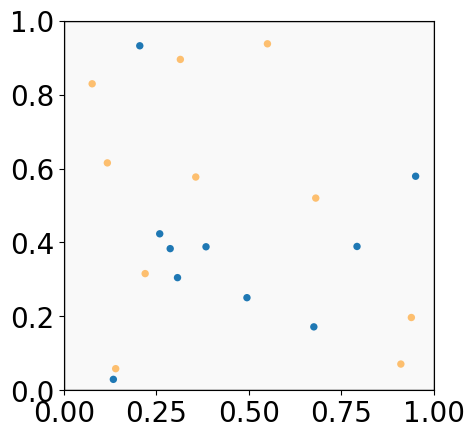

t= 1 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [8 7]
saving file...  0.006186246871948242  seconds
start choosing newX
finished choosing newX, eplased time =  0.042504310607910156
number of leaves = 5


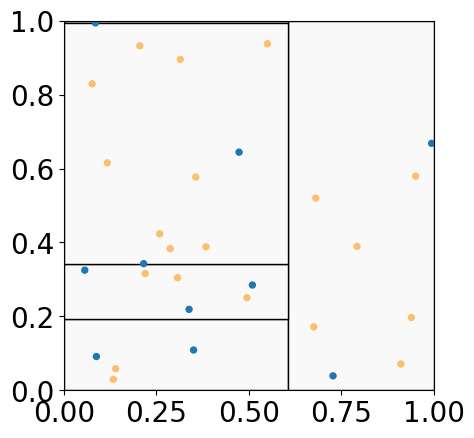

t= 2 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [9 7]
saving file...  0.0045163631439208984  seconds
start choosing newX
finished choosing newX, eplased time =  0.042958736419677734
number of leaves = 7


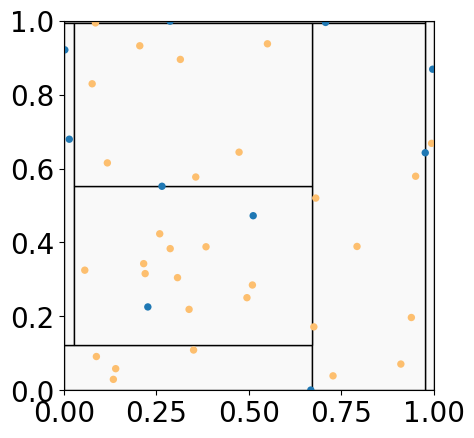

t= 3 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [6 7]
saving file...  0.0003685951232910156  seconds
start choosing newX
finished choosing newX, eplased time =  0.03304338455200195
number of leaves = 7


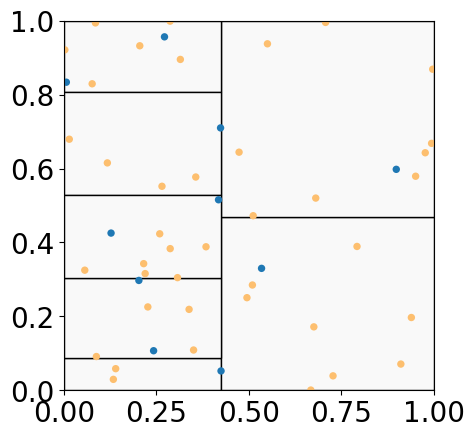

t= 4 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [6 7]
saving file...  0.00283050537109375  seconds
start choosing newX
finished choosing newX, eplased time =  0.03571486473083496
number of leaves = 9


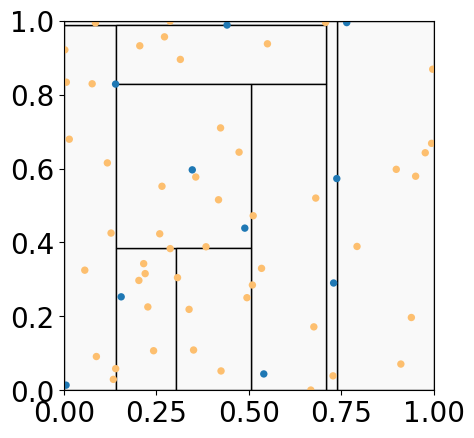

t= 5 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [8 7]
saving file...  0.004232168197631836  seconds
start choosing newX
finished choosing newX, eplased time =  0.07540488243103027
number of leaves = 10


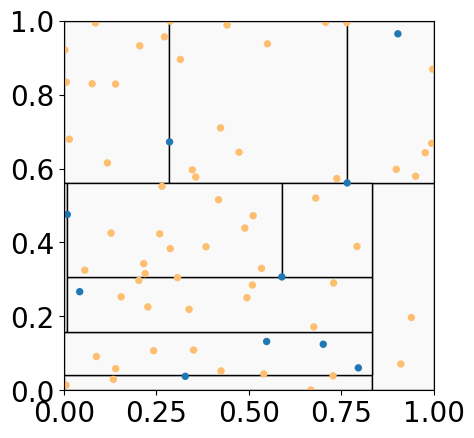

t= 6 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [8 9]
saving file...  0.0008742809295654297  seconds
start choosing newX
finished choosing newX, eplased time =  0.10644197463989258
number of leaves = 10


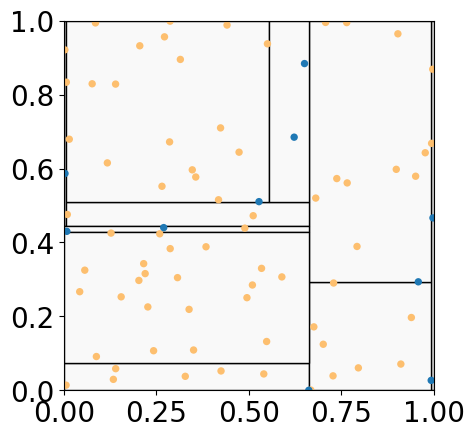

t= 7 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [7 7]
saving file...  0.010248661041259766  seconds
start choosing newX
finished choosing newX, eplased time =  0.026162385940551758
number of leaves = 10


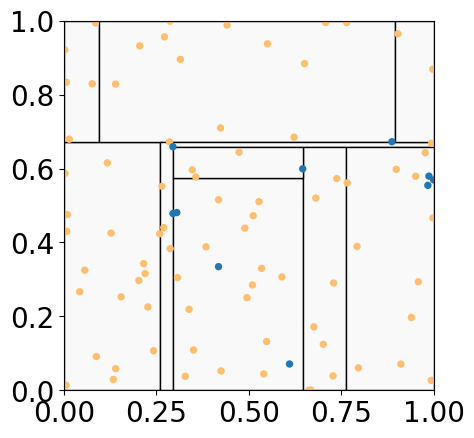

t= 8 , bestid= [15] , besty= [[1.34408438]]
final z= [0 0]  final k= [6 7]
saving file...  0.00038886070251464844  seconds
start choosing newX
finished choosing newX, eplased time =  0.03183794021606445
number of leaves = 10


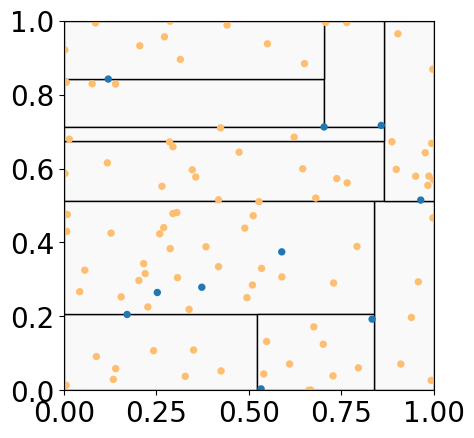

t= 9 , bestid= [90] , besty= [[1.73887003]]
final z= [0 0]  final k= [7 7]
saving file...  0.00037288665771484375  seconds
elapsed time:  14.478516101837158


In [ ]:
#This block defines the options for running the ebo (Ensemble Bayesian Optimization) process.
#It sets parameters such as the input range, dimensionality (dx), the target value (max_value), the number of iterations (T), and the batch size (B).
#Additional parameters control the Gibbs sampling subroutine and the plotting of results.
import numpy as np
import numpy.matlib as nm
import time

##################### define test function ######################
dx = 2
z = sample_z(dx)
k = np.array([10]*dx)
x_range = nm.repmat([[0.],[1.]], 1, dx)
sigma = 0.01
n = 100
f = SampledGpFunc(x_range, dx, z, k, n, sigma)
plot_f(f)
##################################################################

# run ebo
options = {'x_range':x_range, # input domain
           'dx':x_range.shape[1], # input dimension
           'max_value':f.f_max + sigma*5, # target value
           'T':10, # number of iterations
           'B':10, # number of candidates to be evaluated
           'dim_limit':3, # max dimension of the input for each additive function component
           'isplot':1, # 1 if plotting the result; otherwise 0.
           'z':None, 'k':None, # group assignment and number of cuts in the Gibbs sampling subroutine
           'alpha':1., # hyperparameter of the Gibbs sampling subroutine
           'beta':np.array([5.,2.]),
           'opt_n':1000, # points randomly sampled to start continuous optimization of acfun
           'pid':'test3', # process ID for Azure
           'datadir':'tmp_data/', # temporary data directory for Azure
           'gibbs_iter':10, # number of iterations for the Gibbs sampling subroutine
           'useAzure':False, # set to True if use Azure for batch evaluation
           'func_cheap':True, # if func cheap, we do not use Azure to test functions
           'n_add':None, # this should always be None. it makes dim_limit complicated if not None.
           'nlayers': 100, # number of the layers of tiles
           'gp_type':'l1', # other choices are l1, sk, sf, dk, df
           'gp_sigma':0.1, # noise standard deviation
           'n_bo':10, # min number of points selected for each partition
           'n_bo_top_percent': 0.5, # percentage of top in bo selections
           'n_top':10, # how many points to look ahead when doing choose Xnew
           'min_leaf_size':10, # min number of samples in each leaf
           'max_n_leaves':10, # max number of leaves
           'thresAzure':1, # if batch size > thresAzure, we use Azure
           'save_file_name': 'tmp/tmp.pk',
           }

e = ebo(f, options)
start = time.time()
e.run()

print("elapsed time: ", time.time() - start)



### Robot Pushing

In [ ]:
!apt-get install swig
!pip install Box2D
!pip install box2d-py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,051 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123838 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

#### Env

In [ ]:
import numpy as np
import pygame
from Box2D import *
from Box2D.b2 import *

#This section is setting up the physics environment for a robot pushing simulation using the Box2D engine.
#The guiWorld class will manage the rendering of the simulation and handle the physics dynamics of objects in the world.
class guiWorld:
    def __init__(self, fps):
        self.SCREEN_WIDTH, self.SCREEN_HEIGHT = 1000, 1000
        self.TARGET_FPS = fps
        self.PPM = 10.0  # pixels per meter
        self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT), 0, 32)
        pygame.display.set_caption('push simulator')
        self.clock = pygame.time.Clock()
        self.screen_origin = b2Vec2(self.SCREEN_WIDTH / (2 * self.PPM), self.SCREEN_HEIGHT / (self.PPM * 2))
        self.colors = {
            b2_staticBody: (255, 255, 255, 255),
            b2_dynamicBody: (163, 209, 224, 255)
        }

    def draw(self, bodies, bg_color=(64, 64, 64, 0)):
        def my_draw_polygon(polygon, body, fixture):
            vertices = [(self.screen_origin + body.transform * v) * self.PPM for v in polygon.vertices]
            vertices = [(v[0], self.SCREEN_HEIGHT - v[1]) for v in vertices]
            color = self.colors[body.type]
            if body.userData == "obs":
                color = (123, 128, 120, 0)
            if body.userData == "hand":
                color = (174, 136, 218, 0)

            pygame.draw.polygon(self.screen, color, vertices)

        def my_draw_circle(circle, body, fixture):
            position = (self.screen_origin + body.transform * circle.pos) * self.PPM
            position = (position[0], self.SCREEN_HEIGHT - position[1])
            color = self.colors[body.type]
            if body.userData == "hand":
                color = (174, 136, 218, 0)
            pygame.draw.circle(self.screen, color, [int(x) for x in
                                                    position], int(circle.radius * self.PPM))

        b2PolygonShape.draw = my_draw_polygon
        b2CircleShape.draw = my_draw_circle
        # draw the world
        self.screen.fill(bg_color)
        self.clock.tick(self.TARGET_FPS)
        for body in bodies:
            for fixture in body.fixtures:
                fixture.shape.draw(body, fixture)
        pygame.display.flip()


# this is the interface to pybox2d
class b2WorldInterface:
    def __init__(self, do_gui=True):
        self.world = b2World(gravity=(0.0, 0.0), doSleep=True)
        self.do_gui = do_gui
        self.TARGET_FPS = 100
        self.TIME_STEP = 1.0 / self.TARGET_FPS
        self.VEL_ITERS, self.POS_ITERS = 10, 10
        self.bodies = []

        if do_gui:
            self.gui_world = guiWorld(self.TARGET_FPS)
            # raw_input()
        else:
            self.gui_world = None

    def initialize_gui(self):
        if self.gui_world == None:
            self.gui_world = guiWorld(self.TARGET_FPS)
        self.do_gui = True

    def stop_gui(self):
        self.do_gui = False

    def add_bodies(self, new_bodies):
        """ add a single b2Body or list of b2Bodies to the world"""
        if type(new_bodies) == list:
            self.bodies += new_bodies
        else:
            self.bodies.append(new_bodies)

    def step(self, show_display=True, idx=0):
        self.world.Step(self.TIME_STEP, self.VEL_ITERS, self.POS_ITERS)
        if show_display and self.do_gui:
            self.gui_world.draw(self.bodies)


class end_effector:
    def __init__(self, b2world_interface, init_pos, base, init_angle, hand_shape='rectangle', hand_size=(0.3, 1)):
        world = b2world_interface.world
        self.hand = world.CreateDynamicBody(position=init_pos, angle=init_angle)
        self.hand_shape = hand_shape
        self.hand_size = hand_size
        # forceunit for circle and rect
        if hand_shape == 'rectangle':
            rshape = b2PolygonShape(box=hand_size)
            self.forceunit = 30.0
        elif hand_shape == 'circle':
            rshape = b2CircleShape(radius=hand_size)
            self.forceunit = 100.0
        elif hand_shape == 'polygon':
            rshape = b2PolygonShape(vertices=hand_size)
        else:
            raise Exception("%s is not a correct shape" % hand_shape)

        self.hand.CreateFixture(
            shape=rshape,
            density=.1,
            friction=.1
        )
        self.hand.userData = "hand"

        friction_joint = world.CreateFrictionJoint(
            bodyA=base,
            bodyB=self.hand,
            maxForce=2,
            maxTorque=2,
        )
        b2world_interface.add_bodies(self.hand)

    def set_pos(self, pos, angle):
        self.hand.position = pos
        self.hand.angle = angle

    def apply_wrench(self, rlvel=(0, 0), ravel=0):

        avel = self.hand.angularVelocity
        delta_avel = ravel - avel
        torque = self.hand.mass * delta_avel * 30.0
        self.hand.ApplyTorque(torque, wake=True)

        lvel = self.hand.linearVelocity
        delta_lvel = b2Vec2(rlvel) - b2Vec2(lvel)
        force = self.hand.mass * delta_lvel * self.forceunit
        self.hand.ApplyForce(force, self.hand.position, wake=True)

    def get_state(self, verbose=False):
        state = list(self.hand.position) + [self.hand.angle] + \
                list(self.hand.linearVelocity) + [self.hand.angularVelocity]
        if verbose:
            print_state = ["%.3f" % x for x in state]
            print
            "position, velocity: (%s), (%s) " % \
            ((", ").join(print_state[:3]), (", ").join(print_state[3:]))

        return state


def create_body(base, b2world_interface, body_shape, body_size, body_friction, body_density, obj_loc):
    world = b2world_interface.world

    link = world.CreateDynamicBody(position=obj_loc)
    if body_shape == 'rectangle':
        linkshape = b2PolygonShape(box=body_size)
    elif body_shape == 'circle':
        linkshape = b2CircleShape(radius=body_size)
    elif body_shape == 'polygon':
        linkshape = b2PolygonShape(vertices=body_size)
    else:
        raise Exception("%s is not a correct shape" % body_shape)

    link.CreateFixture(
        shape=linkshape,
        density=body_density,
        friction=body_friction,
    )
    friction_joint = world.CreateFrictionJoint(
        bodyA=base,
        bodyB=link,
        maxForce=5,
        maxTorque=2,
    )

    b2world_interface.add_bodies([link])
    return link


def make_base(table_width, table_length, b2world_interface):
    world = b2world_interface.world
    base = world.CreateStaticBody(
        position=(0, 0),
        shapes=b2PolygonShape(box=(table_length, table_width)),
    )

    b2world_interface.add_bodies([base])
    return base


def add_obstacles(b2world_interface, obsverts):
    world = b2world_interface.world
    obs = []
    for verts in obsverts:
        tmp = world.CreateStaticBody(
            position=(0, 0),
            shapes=b2PolygonShape(vertices=verts),
        )
        tmp.userData = "obs"
        obs.append(tmp)

    # add boundaries
    x, y = sm.wbpolygon.exterior.xy
    minx, maxx, miny, maxy = np.min(x), np.max(x), np.min(y), np.max(y)
    centers = [(0, miny - 1), (0, maxy + 1), (minx - 1, 0), (maxx + 1, 0)]
    boxlen = [(maxx - minx, 0.5), (maxx - minx, 0.5), (0.5, maxy - miny), (0.5, maxy - miny)]
    for (pos, blen) in zip(centers, boxlen):
        tmp = world.CreateStaticBody(
            position=pos,
            shapes=b2PolygonShape(box=blen),
        )
        obs.append(tmp)
    b2world_interface.add_bodies(obs)


def run_simulation(world, body, body2, robot, robot2, xvel, yvel, \
                   xvel2, yvel2, rtor, rtor2, simulation_steps,
                   simulation_steps2):
    # simulating push with fixed direction pointing from robot location to body location
    #simulates the robot's actions in pushing objects using Box2D physics.
    #The function applies forces and torques over multiple simulation steps and returns the final positions of the objects.
    desired_vel = np.array([xvel, yvel])
    rvel = b2Vec2(desired_vel[0] + np.random.normal(0, 0.01), desired_vel[1] + np.random.normal(0, 0.01))

    desired_vel2 = np.array([xvel2, yvel2])
    rvel2 = b2Vec2(desired_vel2[0] + np.random.normal(0, 0.01), desired_vel2[1] + np.random.normal(0, 0.01))

    tmax = np.max([simulation_steps, simulation_steps2])
    for t in range(tmax + 100):
        if t < simulation_steps:
            robot.apply_wrench(rvel, rtor)
        if t < simulation_steps2:
            robot2.apply_wrench(rvel2, rtor2)
        world.step()

    return (list(body.position), list(body2.position))


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
import numpy as np


class PushReward:
  #defines a reward function for a robot pushing task, where two objects are pushed toward goal positions.
  #It computes the maximum possible reward and evaluates the reward based on the current positions and velocities of the robots.
    def __init__(self, gui=False):

        # domain of this function
        self.xmin = [-5., -5., -10., -10., 2., 0., -5., -5., -10., -10., 2., 0., -5., -5.]
        self.xmax = [5., 5., 10., 10., 30., 2.*np.pi, 5., 5., 10., 10., 30., 2.*np.pi, 5., 5.]

        # starting xy locations for the two objects
        self.sxy = (0, 2)
        self.sxy2 = (0, -2)
        # goal xy locations for the two objects
        self.gxy = [4, 3.5]
        self.gxy2 = [-4, 3.5]

    @property
    def f_max(self):
        # maximum value of this function
        return np.linalg.norm(np.array(self.gxy) - np.array(self.sxy)) \
            + np.linalg.norm(np.array(self.gxy2) - np.array(self.sxy2))
    @property
    def dx(self):
        # dimension of the input
        return self._dx

    def __call__(self, argv):
        # returns the reward of pushing two objects with two robots
        #evaluates the reward of the robot pushing task by simulating the robots' actions and calculating how much they moved the objects toward their goals.
        #The reward is based on minimizing the distance between the objects and their target locations.
        rx = float(argv[0])
        ry = float(argv[1])
        xvel = float(argv[2])
        yvel = float(argv[3])
        simu_steps = int(float(argv[4]) * 10)
        init_angle = float(argv[5])
        rx2 = float(argv[6])
        ry2 = float(argv[7])
        xvel2 = float(argv[8])
        yvel2 = float(argv[9])
        simu_steps2 = int(float(argv[10]) * 10)
        init_angle2 = float(argv[11])
        rtor = float(argv[12])
        rtor2 = float(argv[13])

        initial_dist = self.f_max

        world = b2WorldInterface(False)
        oshape, osize, ofriction, odensity, bfriction, hand_shape, hand_size = \
            'circle', 1, 0.01, 0.05, 0.01, 'rectangle', (1, 0.3)

        base = make_base(500, 500, world)
        body = create_body(base, world, 'rectangle', (0.5, 0.5), ofriction, odensity, self.sxy)
        body2 = create_body(base, world, 'circle', 1, ofriction, odensity, self.sxy2)

        robot = end_effector(world, (rx,ry), base, init_angle, hand_shape, hand_size)
        robot2 = end_effector(world, (rx2,ry2), base, init_angle2, hand_shape, hand_size)
        (ret1, ret2) = run_simulation(world, body, body2, robot, robot2, xvel, yvel, \
                                      xvel2, yvel2, rtor, rtor2, simu_steps, simu_steps2)

        ret1 = np.linalg.norm(np.array(self.gxy) - ret1)
        ret2 = np.linalg.norm(np.array(self.gxy2) - ret2)
        return initial_dist - ret1 - ret2


#### EBO

In [ ]:
f = PushReward(gui=False)
x_range = np.array(f.xmin + f.xmax).reshape(2,len(f.xmin))
initail_samples = 40
bugdet = 300

def ebo_o(f, initial_samples, budget):
    def sample_from_matrix(range_matrix, n_samples = 10):
        # Get the minimum and maximum values for each column
        min_values = range_matrix[0]
        max_values = range_matrix[1]

        # Sample a value from the range defined by each column
        sampled_values = np.random.uniform(low=min_values, high=max_values, size=(n_samples, len(min_values)))

        return sampled_values

    B = 10
    X = sample_from_matrix(x_range, initail_samples)
    y = np.array([f(x) for x in X]).reshape(-1, 1)
    T = (budget - initial_samples) // B + X.shape[0]//B

    # run ebo
    options = {'x_range':x_range, # input domain
            'dx':x_range.shape[1], # input dimension
            'max_value':f.f_max, # target value
            'X':X, 'y':y, # initial samples
            'T':T, # number of iterations
            'B':B, # number of candidates to be evaluated
            'dim_limit':5, # max dimension of the input for each additive function component
            'isplot':0, # 1 if plotting the result; otherwise 0.
            'z':None, 'k':None, # group assignment and number of cuts in the Gibbs sampling subroutine
            'alpha':1., # hyperparameter of the Gibbs sampling subroutine
            'beta':np.array([5.,2.]),
            'opt_n':1000, # points randomly sampled to start continuous optimization of acfun
            'pid':'test3', # process ID for Azure
            'datadir':'tmp_data/', # temporary data directory for Azure
            'gibbs_iter':10, # number of iterations for the Gibbs sampling subroutine
            'useAzure':False, # set to True if use Azure for batch evaluation
            'func_cheap':True, # if func cheap, we do not use Azure to test functions
            'n_add':None, # this should always be None. it makes dim_limit complicated if not None.
            'nlayers': 100, # number of the layers of tiles
            'gp_type':'l1', # other choices are l1, sk, sf, dk, df
            'gp_sigma':0.1, # noise standard deviation
            'n_bo':10, # min number of points selected for each partition
            'n_bo_top_percent': 0.5, # percentage of top in bo selections
            'n_top':10, # how many points to look ahead when doing choose Xnew
            'min_leaf_size':10, # min number of samples in each leaf
            'max_n_leaves':10, # max number of leaves
            'thresAzure':1, # if batch size > thresAzure, we use Azure
            'save_file_name': '',
            }

    e = ebo(f, options)
    start = time.time()
    e.run()

    print("elapsed time: ", time.time() - start)

ebo_o(f, initail_samples, bugdet)

{'x_range': array([[ -5.        ,  -5.        , -10.        , -10.        ,
          2.        ,   0.        ,  -5.        ,  -5.        ,
        -10.        , -10.        ,   2.        ,   0.        ,
         -5.        ,  -5.        ],
       [  5.        ,   5.        ,  10.        ,  10.        ,
         30.        ,   6.28318531,   5.        ,   5.        ,
         10.        ,  10.        ,  30.        ,   6.28318531,
          5.        ,   5.        ]]), 'dx': 14, 'max_value': 11.072737127026487, 'X': array([[ 1.52074122e-01, -3.75579163e+00,  7.86459061e+00,
         1.62418456e-01,  2.89000724e+01,  9.29181299e-01,
         2.45411253e+00,  4.13616723e+00, -8.26393115e+00,
         7.87985791e+00,  3.13815110e+00,  3.43724183e+00,
         4.04042493e+00,  2.09394525e+00],
       [-2.28498116e+00,  1.96934240e+00, -3.28777965e-01,
        -3.12348012e+00,  1.75730491e+01,  3.53524837e+00,
         1.60491310e+00,  3.16398582e+00, -6.60257768e+00,
         2.88629514e+00,

#### BO

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

f = PushReward(gui=False)
initail_samples = 40
bugdet = 300

def normal_bo(f, initial_samples, budget):
    def f_wrapper(rx, ry, xvel, yvel, simu_steps, init_angle, rx2, ry2, xvel2, yvel2, simu_steps2, init_angle2, rtor, rtor2):
        x = np.array([rx, ry, xvel, yvel, simu_steps, init_angle, rx2, ry2, xvel2, yvel2, simu_steps2, init_angle2, rtor, rtor2])
        return f(x)
    pbounds = {'rx': (f.xmin[0], f.xmax[0]),
               'ry': (f.xmin[1], f.xmax[1]),
               'xvel': (f.xmin[2], f.xmax[2]),
               'yvel': (f.xmin[3], f.xmax[3]),
               'simu_steps': (f.xmin[4], f.xmax[4]),
               'init_angle': (f.xmin[5], f.xmax[5]),
               'rx2': (f.xmin[6], f.xmax[6]),
               'ry2': (f.xmin[7], f.xmax[7]),
               'xvel2': (f.xmin[8], f.xmax[8]),
               'yvel2': (f.xmin[9], f.xmax[9]),
               'simu_steps2': (f.xmin[10], f.xmax[10]),
               'init_angle2': (f.xmin[11], f.xmax[11]),
               'rtor': (f.xmin[12], f.xmax[12]),
               'rtor2': (f.xmin[13], f.xmax[13])}

    optimizer = BayesianOptimization(
        f = f_wrapper,
        pbounds=pbounds,
        verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )

    optimizer.maximize(
        init_points=initail_samples,
        n_iter=bugdet - initail_samples,
    )

    print(optimizer.max)

start_time = time.time()
normal_bo(f, initail_samples, bugdet)
print("elapsed time: ", time.time() - start_time)

|   iter    |  target   | init_a... | init_a... |   rtor    |   rtor2   |    rx     |    rx2    |    ry     |    ry2    | simu_s... | simu_s... |   xvel    |   xvel2   |   yvel    |   yvel2   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 5         | 0.003848  | 3.607     | 0.9219    | 0.8931    | 1.998     | -3.977    | -0.8594   | 1.944     | -0.8582   | 3.399     | 17.01     | 3.276     | 0.2978    | 8.892     | 1.731     |
| 10        | 0.05167   | 3.473     | 5.291     | -3.758    | -2.208    | 0.8576    | 4.696     | 0.6103    | -4.814    | 24.42     | 8.523     | 6.142     | -2.243    | 7.271     | 4.942     |
| 20        | 0.1045    | 4.215     | 2.833     | -1.179    | -0.8919   | -0.9852   | -1.826    | 1.219     | -0.6975   | 29.27     | 20.98     | -6.029    | -1.466    | -3.133    | 5.953     |
| 23        | 0.2527    | 3.72